# EBBE-14 Port Aster PoP Model built on old events to HALO: 2019 Postpaid discovery + PattertnAnalyzer user manual

* Only Postpaid PRIV segment
* Churn/Annex decisions between 2019-01-01 and 2019-05-31
* Events are collected for 2018-01-01 to 2019-05-31 period
* Events must happen always before decision with some delta (time before): for event based retention with daily campaign no longer delta than 24 hours is recommended!

### Imports/ Libraries used

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

### Spark details

In [3]:
spark = SparkSession.builder.master("yarn").getOrCreate()

In [4]:
spark.sparkContext.master

'yarn'

In [5]:
spark.version

'2.3.0.cloudera4'

In [6]:
import sys
sys.version

'3.6.8 |Anaconda custom (64-bit)| (default, Dec 30 2018, 01:22:34) \n[GCC 7.3.0]'

### Hive / database details

In [7]:
spark.sql("show databases").show(200, False)

+----------------+
|databaseName    |
+----------------+
|capex_allocation|
|default         |
|ebr             |
|ebr_test        |
|pa_outputs      |
|tdatamodel      |
|tmodel          |
+----------------+



All data is stored in ebr_test schema in Hive.<br>
This is also our "write schema" for the use case.<br>

Let's use the naming convention when all analytical outputs are prefixed with analyst's initials not to confuse with each others outputs using PatternAnalyzer: 

In [7]:
spark.sql("use ebr_test")
spark.sql("show tables").show(20, False)

+--------+---------------------------------------------------------------+-----------+
|database|tableName                                                      |isTemporary|
+--------+---------------------------------------------------------------+-----------+
|ebr_test|a                                                              |false      |
|ebr_test|bt_pa_postpaid_2019_events                                     |false      |
|ebr_test|bt_pa_postpaid_2019_events_to_score                            |false      |
|ebr_test|bt_pa_postpaid_2019_model_rules__s0_0025__l10____c0_033__n0_005|false      |
|ebr_test|bt_pa_postpaid_2019_model_rules__s0_0025__l10____c0_33__n0_005 |false      |
|ebr_test|bt_pa_postpaid_2019_pa_fp_ev_s0_0025__l10                      |false      |
|ebr_test|bt_pa_postpaid_2019_pa_fp_ev_s0_01__l10                        |false      |
|ebr_test|bt_pa_postpaid_2019_pa_fp_s0_0025__l10                         |false      |
|ebr_test|bt_pa_postpaid_2019_pa_fp_s0_01__

# Discovery EBR Postpaid

## Input Data

* Table *ebr_test.events*: all postpaid events, format ORC
* Table *ebr_test.mdl_postpaid_new_pop*: all prepaid events, format ORC


In [8]:
tbl_decisions = "ebr_test.mdl_postpaid_new_pop"
tbl_events = "ebr_test.events"

## Postpaid Decisions

We need to filter out old decisions and focus on **PRIV** segment only.

In [9]:
spark.sql("desc mdl_postpaid_new_pop").show(200, False)

+-------------+---------+-------+
|col_name     |data_type|comment|
+-------------+---------+-------+
|cont_id      |int      |null   |
|decision     |string   |null   |
|decision_date|timestamp|null   |
|expire_date  |timestamp|null   |
|seg          |string   |null   |
+-------------+---------+-------+



In [10]:
spark.sql("select * from mdl_postpaid_new_pop limit 10").show(200, False)

+--------+--------+-------------------+-------------------+----+
|cont_id |decision|decision_date      |expire_date        |seg |
+--------+--------+-------------------+-------------------+----+
|22550381|ANNEX   |2018-01-09 00:00:00|2017-12-28 00:00:00|SOHO|
|22550489|ANNEX   |2018-08-30 00:00:00|2018-10-17 00:00:00|PRIV|
|22550765|REZ_MNP |2017-10-20 11:23:41|2017-11-22 00:00:00|VSE |
|22550994|ANNEX   |2018-03-19 00:00:00|2018-02-20 00:00:00|SOHO|
|22551037|ANNEX   |2018-08-02 00:00:00|2019-01-12 00:00:00|PRIV|
|22551468|ANNEX   |2018-07-30 00:00:00|2018-09-06 00:00:00|PRIV|
|22551491|ANNEX   |2019-02-23 00:00:00|2019-05-22 00:00:00|VSE |
|22551528|ANNEX   |2018-05-19 00:00:00|2018-08-04 00:00:00|PRIV|
|22551812|ANNEX   |2017-07-31 00:00:00|2017-12-19 00:00:00|PRIV|
|22551986|ANNEX   |2019-01-10 00:00:00|2019-03-28 00:00:00|PRIV|
+--------+--------+-------------------+-------------------+----+



In [11]:
decisions_pd = spark.sql("select decision, count(*) ile from ebr_test.mdl_postpaid_new_pop group by decision").toPandas()
decisions_pd.head()

decision      ile
0    REZ_MNP   359970
1      ANNEX  2070112
2  REZ_OTHER   232312

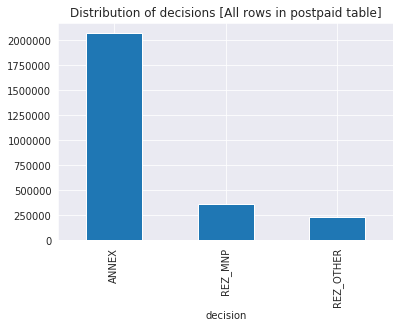

In [12]:
decisions_pd.sort_values("decision").plot.bar("decision", title="Distribution of decisions [All rows in postpaid table]", legend=False)

In [13]:
segments_pd = spark.sql("select seg, count(*) ile from ebr_test.mdl_postpaid_new_pop group by seg").toPandas()
segments_pd.head()

seg      ile
0  SOHO   171405
1   VSE   314449
2  PRIV  2070933
3   SMB   105607

### NOTE! We have legacy data only. What about T-Morrow?

In [14]:
segments_pd.sort_values("seg").plot.bar("seg", title="Distribution of segments [All rows in postpaid table]", legend=False)

Only **PRIV** is relevant, we need to filter 2019 decisions (2019-01-01 - 2019-05-31) later on<br>
Let's see decision distribution by year.

In [15]:
sql_yr_dec_distr = """
select
    s.*,
    sum(ile) over (partition by year) all_decisions,
    ile / sum(ile) over (partition by year) decision_share
from (
        select
            year(from_unixtime(unix_timestamp(decision_date, 'yyyy-MM-dd HH:mm:ss'))) year,
            decision,
            count(*) ile
        from mdl_postpaid_new_pop
        where seg = 'PRIV'
        group by year(from_unixtime(unix_timestamp(decision_date, 'yyyy-MM-dd HH:mm:ss'))), decision
        order by year(from_unixtime(unix_timestamp(decision_date, 'yyyy-MM-dd HH:mm:ss'))), decision
        ) s
"""


yr_dec_distr_df = spark.sql(sql_yr_dec_distr)
yr_dec_distr_df.show(200, False)

yr_dec_distr_pd = yr_dec_distr_df.toPandas()

+----+---------+------+-------------+-------------------+
|year|decision |ile   |all_decisions|decision_share     |
+----+---------+------+-------------+-------------------+
|2018|ANNEX    |805198|1010456      |0.7968659694237057 |
|2018|REZ_MNP  |124380|1010456      |0.12309294021709011|
|2018|REZ_OTHER|80878 |1010456      |0.08004109035920416|
|2019|ANNEX    |275029|348853       |0.7883807792967238 |
|2019|REZ_MNP  |41498 |348853       |0.11895554861216616|
|2019|REZ_OTHER|32326 |348853       |0.09266367209111001|
|2017|ANNEX    |525964|711624       |0.739103796386856  |
|2017|REZ_MNP  |115393|711624       |0.16215445235124168|
|2017|REZ_OTHER|70267 |711624       |0.09874175126190235|
+----+---------+------+-------------+-------------------+



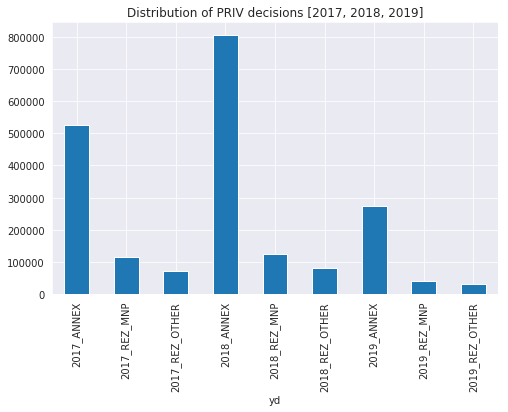

In [16]:
yr_dec_distr_pd.head(200)

yr_dec_distr_pd["yd"] = yr_dec_distr_pd[["year", "decision"]].apply(lambda x: "_".join(x.astype(str)), axis=1)
yr_dec_distr_pd.sort_values("yd").plot.bar(x="yd", y="ile", title="Distribution of PRIV decisions [2017, 2018, 2019]",  figsize=(8, 5), legend=False)

We have only 5 months available for 2019, let's normalize the distribution per each year

In [17]:
yr_dec_distr_pd.sort_values("yd").plot.bar(x="yd", y="decision_share", title="% Distribution of PRIV decisions [2017, 2018, 2019]", figsize=(8, 5), legend=False)

We have data for each segment, let's see distribution:

In [18]:
spark.sql("select decision, count(*) ile from mdl_postpaid_new_pop where seg = 'PRIV' group by decision").show(200, False)

+---------+-------+
|decision |ile    |
+---------+-------+
|REZ_MNP  |281271 |
|ANNEX    |1606191|
|REZ_OTHER|183471 |
+---------+-------+



Sanity check, is it possible for a single cont_id to have more than 1 decision for analyzed period?

In [19]:
## Analiza czy zmieniają się statusy w ciągu kolek=jnych dni: rozkład cont_id i stausów na każdy dzień i potem suma ile ma distinct statusów 

distr_query = """
    select
        cont_id,
        count(*) decisions
    from (select distinct cont_id, decision from {}) s1
    group by cont_id
    order by count(*) desc
""".format(tbl_decisions)


spark.sql(distr_query).show(5, False) 

+--------+---------+
|cont_id |decisions|
+--------+---------+
|22041011|1        |
|29983598|1        |
|25728586|1        |
|29164002|1        |
|29053581|1        |
+--------+---------+
only showing top 5 rows



Ok, always **only 1 decision**

## Postpaid Events

In [20]:
spark.sql("desc events").show(200, False)

+-------------------+---------+-------+
|col_name           |data_type|comment|
+-------------------+---------+-------+
|cont_id            |int      |null   |
|event_dt           |timestamp|null   |
|event_type         |string   |null   |
|event_name         |string   |null   |
|event_name_extended|string   |null   |
|event_description  |string   |null   |
|insert_ts          |timestamp|null   |
+-------------------+---------+-------+



In [21]:
spark.sql("select * from events limit 10").show(200)

+---------+-------------------+-----------------+--------------------+--------------------+--------------------+--------------------+
|  cont_id|           event_dt|       event_type|          event_name| event_name_extended|   event_description|           insert_ts|
+---------+-------------------+-----------------+--------------------+--------------------+--------------------+--------------------+
|153502951|2018-12-31 14:31:41|           TD_RIR|ICC Backoffice:TD...|         EXPERT_DSOK|Kontakt Klient <>...|2019-01-02 02:03:...|
| 98289690|2018-12-31 14:31:45|           TD_RIR|DEALERS:TD_RIR_0....|        FRKONSULTANT|Kontakt Klient <>...|2019-01-02 02:03:...|
| 48830635|2018-12-31 14:31:48|           TD_RIR|CC_ECC:TD_RIR_ove...|     DEFAULT_T-TTHOT|Kontakt Klient <>...|2019-01-02 02:03:...|
|154742788|2018-12-31 14:31:52|           TD_RIR|AREA_B:TD_RIR_0.3...|     SALON_KIEROWNIK|Kontakt Klient <>...|2019-01-02 02:03:...|
| 66992010|2018-12-31 14:31:56|           TD_RIR|AREA_A:TD_RIR

In [22]:
spark.sql("select min(event_dt) min_event_dt, max(event_dt) max_event_dt, count(*) rows, count(distinct cont_id) unique_cont_ids from events limit 10").show(200, False)

+-------------------+-------------------+--------+---------------+
|min_event_dt       |max_event_dt       |rows    |unique_cont_ids|
+-------------------+-------------------+--------+---------------+
|2018-01-01 00:00:00|2021-01-01 00:00:00|78708097|10465768       |
+-------------------+-------------------+--------+---------------+



#### To be clarified with Paweł
* Bad header probably: **event_name** and **event_name_extended** are swapped probably
* one row with 2021 year (to be filtered out)
* a few null event_types (to be filtered out)

<br>event_type distribution:


In [23]:
sql_yr_event_distr = """
select
    
    s.*,
    sum(ile) over (partition by year) all_events,
    ile / sum(ile) over (partition by year) event_share
from (
        select
            year(from_unixtime(unix_timestamp(event_dt, 'yyyy-MM-dd HH:mm:ss'))) year,
            event_type,
            count(*) ile
        from ebr_test.events
        group by year(from_unixtime(unix_timestamp(event_dt, 'yyyy-MM-dd HH:mm:ss'))), event_type
        order by year(from_unixtime(unix_timestamp(event_dt, 'yyyy-MM-dd HH:mm:ss'))), event_type
        ) s
"""


yr_events_distr_df = spark.sql(sql_yr_event_distr)
yr_events_distr_df.show(200, False)

yr_events_distr_pd = yr_events_distr_df.filter("year is not null and year <> 2021").orderBy("year", "ile").toPandas()

+----+-------------------------+--------+----------+---------------------+
|year|event_type               |ile     |all_events|event_share          |
+----+-------------------------+--------+----------+---------------------+
|2018|TD_RIR                   |28070328|50393379  |0.557024128110163    |
|2018|bills                    |6447412 |50393379  |0.1279416488424005   |
|2018|dunning                  |5597445 |50393379  |0.11107500848474558  |
|2018|int_feedback             |155048  |50393379  |0.003076753396512665 |
|2018|zwroty                   |24996   |50393379  |4.960175423045158E-4 |
|2018|int_nice                 |274689  |50393379  |0.005450894650267449 |
|2018|competition_pos          |3633915 |50393379  |0.07211096124353955  |
|2018|poach_call               |376207  |50393379  |0.007465405326362418 |
|2018|REKLAMACJA_STOP_NEGATYWNA|124120  |50393379  |0.002463021977549868 |
|2018|SNA_churn                |201932  |50393379  |0.0040071137122993875|
|2018|atg                

In [24]:
yr_events_distr_pd.head(30)

year                 event_type       ile  all_events  event_share
0   2018                     zwroty     24996    50393379     0.000496
1   2018                  MKT_ZGODA     36261    50393379     0.000720
2   2018  REKLAMACJA_STOP_NEGATYWNA    124120    50393379     0.002463
3   2018           REKLAMACJA_START    149154    50393379     0.002960
4   2018               int_feedback    155048    50393379     0.003077
5   2018                  SNA_churn    201932    50393379     0.004007
6   2018                   int_nice    274689    50393379     0.005451
7   2018                        atg    286280    50393379     0.005681
8   2018                 poach_call    376207    50393379     0.007465
9   2018            competition_pos   3633915    50393379     0.072111
10  2018          voice_interaction   5015592    50393379     0.099529
11  2018                    dunning   5597445    50393379     0.111075
12  2018                      bills   6447412    50393379     0.127942
13  2018                     TD_RIR  28070328    50393379     0.557024
14  2019                     zwroty      9449    28314619     0.000334
15  2019                  MKT_ZGODA     19021    28314619     0.000672
16  2019                  SNA_churn     74013    28314619     0.002614
17  2019  REKLAMACJA_STOP_NEGATYWNA     79368    28314619     0.002803
18  2019           REKLAMACJA_START     87634    28314619     0.003095
19  2019               int_feedback    106318    28314619     0.003755
20  2019                 poach_call    152861    28314619     0.005399
21  2019                        atg    159593    28314619     0.005636
22  2019                   int_nice    324710    28314619     0.011468
23  2019            competition_pos   1000717    28314619     0.035343
24  2019          voice_interaction   1929484    28314619     0.068144
25  2019                    dunning   3351364    28314619     0.118362
26  2019                      bills   3803491    28314619     0.134330
27  2019                     TD_RIR  17216596    28314619     0.608046

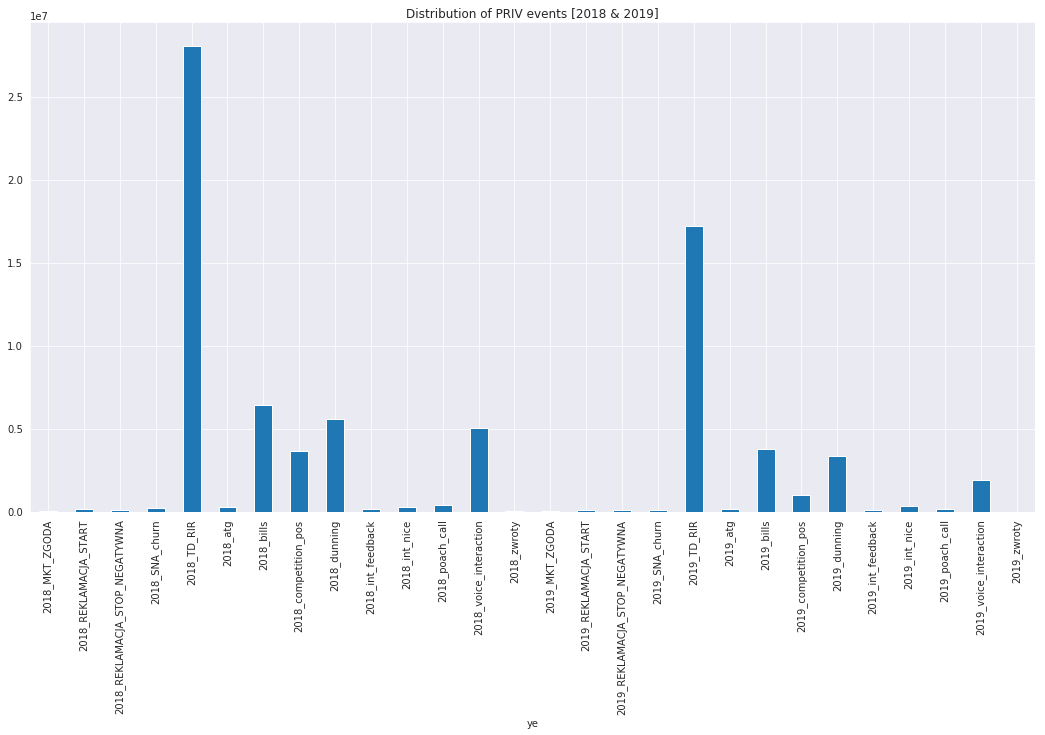

In [25]:
yr_events_distr_pd["ye"] = yr_events_distr_pd[["year", "event_type"]].apply(lambda x: "_".join(x.astype(str)), axis=1)
yr_events_distr_pd.sort_values("ye").plot.bar(x="ye", y="ile", title="Distribution of PRIV events [2018 & 2019]", figsize=(18, 9), legend=False)

In [26]:
yr_events_distr_pd.sort_values(["event_type", "year"]).plot.bar(x="ye", y="event_share", title="% Distribution of PRIV events [2018 & 2019]", figsize=(18, 9), legend=False)

TD_RIR dominates other events, let's see distribution without TD_RIR:

In [27]:
yr_events_distr_pd[yr_events_distr_pd.event_type != "TD_RIR"].sort_values(["event_type", "year"]).plot.bar(x="ye", y="event_share", title="% Distribution of PRIV events [2018 & 2019]", figsize=(18, 9), legend=False)

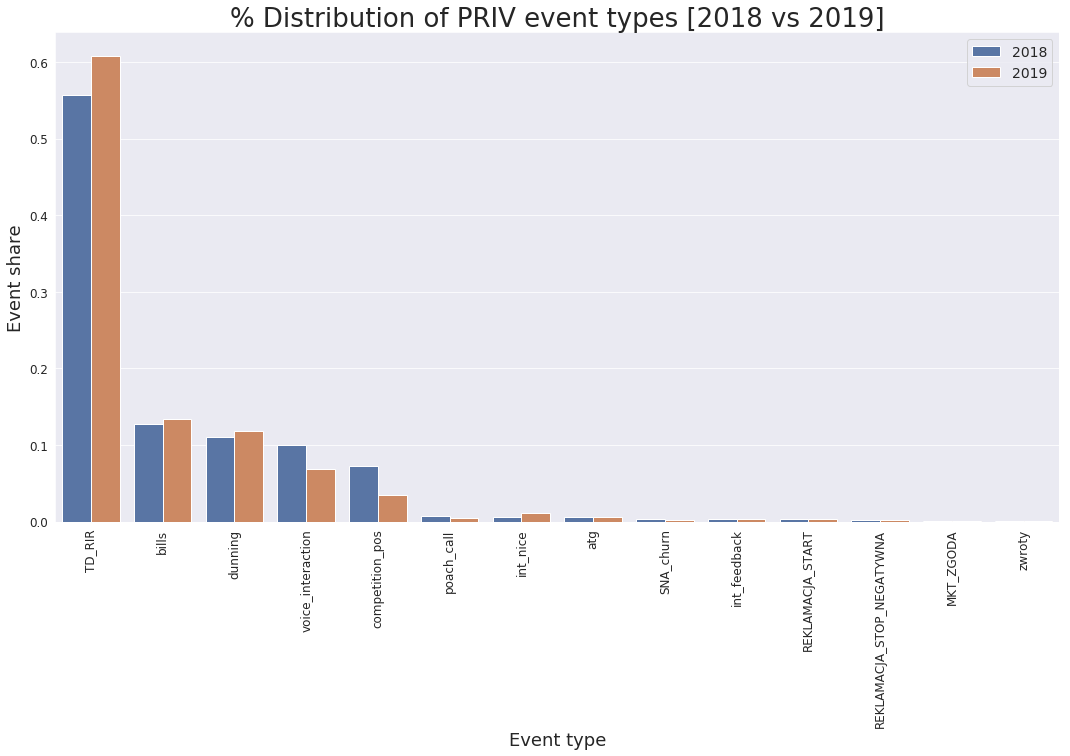

In [28]:
plt.figure(figsize=(18, 9))

sns.barplot(x="event_type", hue="year", y="event_share",  palette="deep", data=yr_events_distr_pd.sort_values("ile", ascending=False))
plt.title("% Distribution of PRIV event types [2018 vs 2019]", fontsize=26)
plt.xlabel("Event type", fontsize=18)
plt.ylabel("Event share", fontsize=18)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.show()

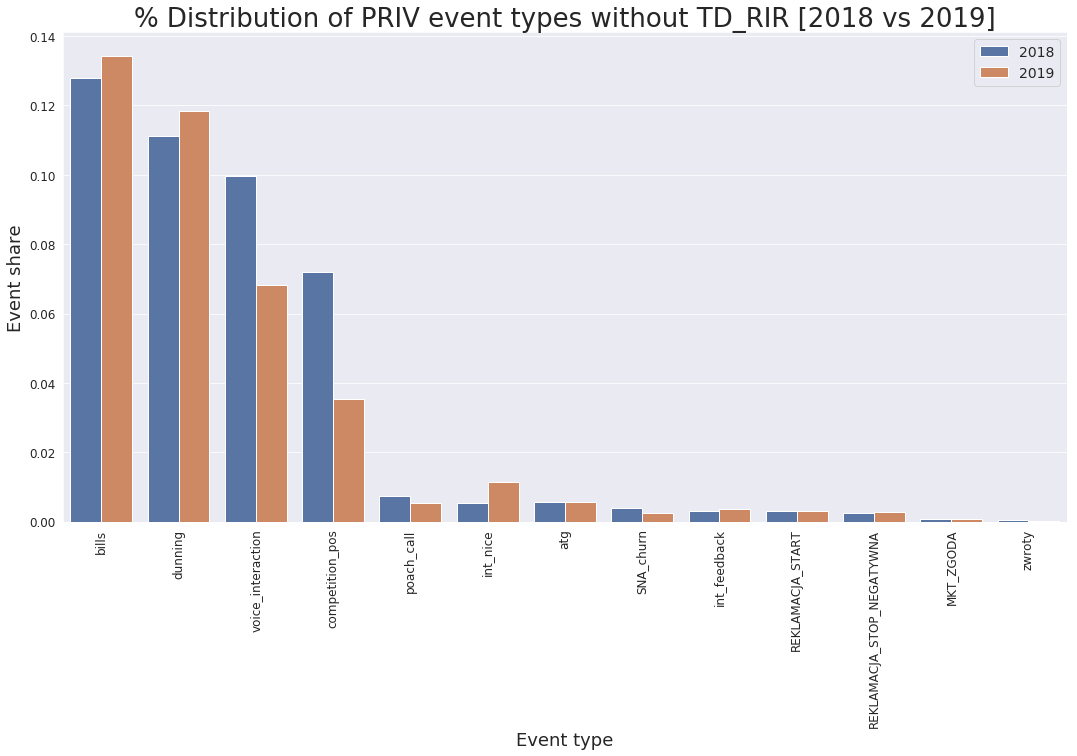

In [29]:
plt.figure(figsize=(18, 9))

sns.barplot(x="event_type", hue="year", y="event_share",  palette="deep", data=yr_events_distr_pd.loc[yr_events_distr_pd.event_type != "TD_RIR"].sort_values("ile", ascending=False))
plt.title("% Distribution of PRIV event types without TD_RIR [2018 vs 2019]", fontsize=26)
plt.xlabel("Event type", fontsize=18)
plt.ylabel("Event share", fontsize=18)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.show()

## The approach for creating PatternAnalyzer input tablele

#### Steps:
* Decisions: unique cont_id for all decisions for Jan - May (inclusive) 2019
* Events generated for 2018 & 2019: 2018-01-01 - 2019-05-31 <- overlapping periods with decisions will be filtered by the next condition
* events only BEFORE **decision timestamp**
* only **seg == "PRIV"**
* events only for defined above **target population**

#### Business questions:
* Should we build EBR models only for **retention period** customers or also for everyone with **open contract status**  <- if "open" share is significant, I would reccomend to build model also for "open contract customers", pattern analyzer can handle them accordingly if they have different patterns leading to resignation
* Should we build a single model for all churn or build separate models:
    * for Mobile Number Portability (MNP) churn
    * other voluntary churn 

## Creating the final input for PatternAnalyzer: Target Population 

In [30]:
spark.sql("desc mdl_postpaid_new_pop").show(200, False)

+-------------+---------+-------+
|col_name     |data_type|comment|
+-------------+---------+-------+
|cont_id      |int      |null   |
|decision     |string   |null   |
|decision_date|timestamp|null   |
|expire_date  |timestamp|null   |
|seg          |string   |null   |
+-------------+---------+-------+



In [31]:
spark.sql("select * from mdl_postpaid_new_pop limit 10").show(200, False)

+--------+--------+-------------------+-------------------+----+
|cont_id |decision|decision_date      |expire_date        |seg |
+--------+--------+-------------------+-------------------+----+
|22550381|ANNEX   |2018-01-09 00:00:00|2017-12-28 00:00:00|SOHO|
|22550489|ANNEX   |2018-08-30 00:00:00|2018-10-17 00:00:00|PRIV|
|22550765|REZ_MNP |2017-10-20 11:23:41|2017-11-22 00:00:00|VSE |
|22550994|ANNEX   |2018-03-19 00:00:00|2018-02-20 00:00:00|SOHO|
|22551037|ANNEX   |2018-08-02 00:00:00|2019-01-12 00:00:00|PRIV|
|22551468|ANNEX   |2018-07-30 00:00:00|2018-09-06 00:00:00|PRIV|
|22551491|ANNEX   |2019-02-23 00:00:00|2019-05-22 00:00:00|VSE |
|22551528|ANNEX   |2018-05-19 00:00:00|2018-08-04 00:00:00|PRIV|
|22551812|ANNEX   |2017-07-31 00:00:00|2017-12-19 00:00:00|PRIV|
|22551986|ANNEX   |2019-01-10 00:00:00|2019-03-28 00:00:00|PRIV|
+--------+--------+-------------------+-------------------+----+



In [32]:
spark.sql("select count(*) all_id, count(distinct cont_id) unique_id from {}".format(tbl_decisions)).show(200, False)

+-------+---------+
|all_id |unique_id|
+-------+---------+
|2662394|2662394  |
+-------+---------+



Are cont_id unique for decisions?<br>
Yes, only unique cont_ids

## Creating final input for PatternAnalyzer: Adding Events for Target Population (Decision) 

This part will be a sub query with relevant decisions of target population:

In [33]:
sql_target = """
    select
      t.*,
      case when decision in ('REZ_MNP', 'REZ_OTHER') then "CHURN" else "ANNEX" end churn
    from {} t
    where
        seg = 'PRIV'
        and decision_date >= '2019-01-01 00:00:00'
        and decision_date < '2019-06-01 00:00:00'
""".format(tbl_decisions)


postpaid_target_df = spark.sql(sql_target)

In [34]:
postpaid_target_df.show(10, False)

+--------+--------+-------------------+-------------------+----+-----+
|cont_id |decision|decision_date      |expire_date        |seg |churn|
+--------+--------+-------------------+-------------------+----+-----+
|22551986|ANNEX   |2019-01-10 00:00:00|2019-03-28 00:00:00|PRIV|ANNEX|
|22552616|ANNEX   |2019-01-09 00:00:00|2019-03-18 00:00:00|PRIV|ANNEX|
|22552749|ANNEX   |2019-04-18 00:00:00|2019-06-01 00:00:00|PRIV|ANNEX|
|22553235|ANNEX   |2019-03-20 00:00:00|2019-03-03 00:00:00|PRIV|ANNEX|
|22553386|ANNEX   |2019-03-21 00:00:00|2019-08-16 00:00:00|PRIV|ANNEX|
|22553814|ANNEX   |2019-03-12 00:00:00|2019-04-21 00:00:00|PRIV|ANNEX|
|22553870|ANNEX   |2019-01-08 00:00:00|2019-01-07 00:00:00|PRIV|ANNEX|
|22554063|ANNEX   |2019-03-28 00:00:00|2019-05-19 00:00:00|PRIV|ANNEX|
|22554452|ANNEX   |2019-04-28 00:00:00|2019-04-12 00:00:00|PRIV|ANNEX|
|22555477|ANNEX   |2019-04-05 00:00:00|2019-03-05 00:00:00|PRIV|ANNEX|
+--------+--------+-------------------+-------------------+----+-----+
only s

In [35]:
postpaid_target_df.count()

348853

In [36]:
postpaid_target_df.groupBy("churn").count().show()

+-----+------+
|churn| count|
+-----+------+
|CHURN| 73824|
|ANNEX|275029|
+-----+------+



#### time_delta: decide how much time we want to have between the "last event" in the sequence and the actual "decision" (like a prediction horizon)

This is needed for getting rid off any artifacts which might be only "technically correlated" with decisions but bring no real value to the model - like events generated by processing of a resignation request.<br>
Please note, standard condition like "event_timestamp" < "decision_timestamp" might be not sufficient. At the same time, time_delta should not be grater than 24 hours for Event based campaign.

In [99]:
event_column = "event_name"

time_delta = 24*60*60   # delta is in seconds: here 24*60*60 = 86400 seconds = 24 hours
#time_delta = 0           # no delta, decision can be right after the last event in the sequence 

#### Get events for target population and add decisions to events (PatternAnalyzer needs to have terminating events in the same column as other events)

In [100]:
sql_events_target = """
    select
        t2.cont_id id,
        t2.{2} event,
        t2.event_dt time
    from
        (
            select
              t.*,
              case when decision in ('REZ_MNP', 'REZ_OTHER') then "CHURN" else "ANNEX" end churn
            from {0} t
            where
                seg = 'PRIV'
                and decision_date >= '2019-01-01 00:00:00'
                and decision_date < '2019-06-01 00:00:00'
        ) t1
        join {1} t2 on t2.cont_id = t1.cont_id
    where
        event_dt < from_unixtime(unix_timestamp(decision_date) - {3})
        and event_dt >= '2019-01-01 00:00:00'
        and event_dt < '2019-06-01 00:00:00'
        
        
    union
        
        select
            t3.cont_id,
            t3.churn,
            t3.decision_date
        from
            (
            select
              t.*,
              case when decision in ('REZ_MNP', 'REZ_OTHER') then "CHURN" else "ANNEX" end churn
            from {0} t
            where
                seg = 'PRIV'
                and decision_date >= '2019-01-01 00:00:00'
                and decision_date < '2019-06-01 00:00:00'
        ) t3
    
    
""".format(tbl_decisions, tbl_events, event_column, time_delta)


postpaid_target_events_df = spark.sql(sql_events_target).cache()

In [101]:
spark.sql("select * from ebr_test.bt_pa_postpaid_2019_events limit 10").show(200, False)

+---------+----------------------------------------------+-------------------+
|id       |event                                         |time               |
+---------+----------------------------------------------+-------------------+
|111446223|CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT|2019-01-21 17:51:21|
|141446791|OTHER:TD_RIR_UNKN:HANDSET_REPLACEMENT         |2019-01-28 18:04:34|
|121341206|CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT|2019-01-21 18:11:30|
|65193398 |CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT|2019-01-25 13:35:52|
|143822597|bill_shocking                                 |2019-01-05 00:00:00|
|78862303 |AREA_A:TD_RIR_0.3_0.5:SALON_KONSULTANT        |2019-01-18 15:34:05|
|32890404 |EXTERNAL_CALL_CENTER:TD_RIR_0.0_0.3:ECC       |2019-01-21 14:30:20|
|142590870|AREA_B:TD_RIR_over_0.5:SALON_KONSULTANT       |2019-01-21 14:40:58|
|70671224 |CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT|2019-01-18 18:00:35|
|142844938|DEALERS:TD_RIR_0.0_0.3:FRKONSULTANT      

### saving the final input as a Hive table

In [102]:
postpaid_target_events_df.write.format("orc").mode("overwrite").saveAsTable("ebr_test.bt_pa_postpaid_2019_events")

### Analyzing the input table

In [103]:
postpaid_target_events_df.groupBy("event").count().orderBy("count", ascending=False).show(20, False)

+----------------------------------------------+------+
|event                                         |count |
+----------------------------------------------+------+
|ANNEX                                         |275029|
|CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT|108386|
|bill_shocking                                 |99224 |
|often_interactions2                           |91121 |
|CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT|85944 |
|CHURN                                         |73824 |
|DEALERS:TD_RIR_0.3_0.5:FRKONSULTANT           |42272 |
|CC_TELESALES_FOC:TD_RIR_0.0_0.3:HOTLINE_FOC   |41915 |
|atg_visit                                     |36916 |
|bills_nonpayer                                |29391 |
|comp_call_WWW                                 |28148 |
|DEALERS:TD_RIR_0.0_0.3:FRKONSULTANT           |27938 |
|OTHER:TD_RIR_UNKN:KIWI                        |24399 |
|churn_sentence                                |19692 |
|AREA_A:TD_RIR_0.3_0.5:SALON_KONSULTANT        |

In [104]:
print("The final input table has {:,} rows".format(postpaid_target_events_df.count()))

The final input table has 1,312,561 rows


In [105]:
postpaid_target_events_pd = postpaid_target_events_df.groupBy("event").count().orderBy("count", ascending=False).toPandas()

In [106]:
postpaid_target_events_pd.head(20)

event   count
0   ANNEX                                           275029
1   CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT  108386
2   bill_shocking                                   99224 
3   often_interactions2                             91121 
4   CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT  85944 
5   CHURN                                           73824 
6   DEALERS:TD_RIR_0.3_0.5:FRKONSULTANT             42272 
7   CC_TELESALES_FOC:TD_RIR_0.0_0.3:HOTLINE_FOC     41915 
8   atg_visit                                       36916 
9   bills_nonpayer                                  29391 
10  comp_call_WWW                                   28148 
11  DEALERS:TD_RIR_0.0_0.3:FRKONSULTANT             27938 
12  OTHER:TD_RIR_UNKN:KIWI                          24399 
13  churn_sentence                                  19692 
14  AREA_A:TD_RIR_0.3_0.5:SALON_KONSULTANT          17112 
15  CC_IN-LIFE:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT    16811 
16  UNKNOWN:TD_RIR_0.3_0.5:ADMIN                    15508 
17  AREA_B:TD_RIR_0.3_0.5:SALON_KONSULTANT          15325 
18  OTHER:TD_RIR_UNKN:HANDSET_REPLACEMENT           14398 
19  DEALERS:TD_RIR_over_0.5:FRKONSULTANT            14001

In [107]:
postpaid_target_events_pd.describe()

count
count  818.000000   
mean   1604.597800  
std    12470.283219 
min    1.000000     
25%    3.000000     
50%    14.000000    
75%    92.000000    
max    275029.000000

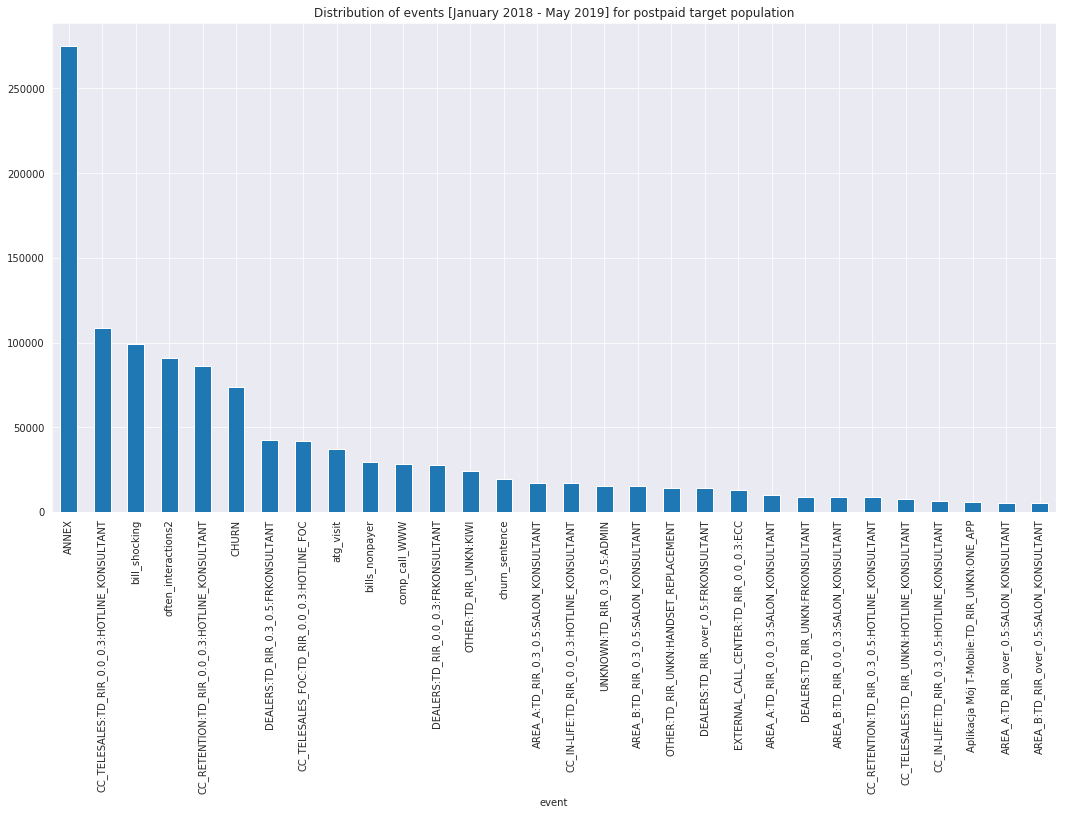

In [108]:
postpaid_target_events_pd.iloc[:30, :].plot(kind="bar", y="count", x="event", title="Distribution of events [January 2018 - May 2019] for postpaid target population", figsize=(18, 9), legend=False)

## Objectives for PatternAnalyzer:

Our objective is now to:
* Transform event data to **path** form where single cont_id has only one row with the whole event sequence (path) 
* Find frequent **patterns** in path data and ignore not relevant events
* Create model / rules for scoring new datasets
* Score new dataset with new EBR model created with PatternAnalyzer

## Run PatternAnalyzer - Step 1: build transformed **path_table**

Please consider below hello world example:
* we have an event table below
* each id has multiple rows for different events
* some of events are the terminators (like "Churn" and "Annex")
* we need to transform events to paths, so each id can have only one row in the output table

<img src="img/transform2.PNG">


We will need to use **patternAnalysis.jar** which should be available in the notebook's folder:

Just run:
* "! ls -lh" to list files in the folder
* "! spark2-submit patternAnalysis.jar --help" or "! spark2-submit patternAnalysis.jar --help" to see the help screen with options for PatternAnalyzer

In [109]:
!ls -lh

total 3.3M
-rw-rw-r-- 1 tertilb tertilb 1.6M Jun  7 08:53 EBBE-14 Port Astr PoP Model on old events.ipynb
-rw-rw-r-- 1 tertilb tertilb 1.7M Jun  6 23:49 EBR_Postpaid_Dis_2019.ipynb
-rw-rw-r-- 1 tertilb tertilb  49K Jun  6 23:32 err.txt
drwxrwxr-x 3 tertilb tertilb 4.0K Jun  5 21:33 img
drwxrwxr-x 2 tertilb tertilb 4.0K Jun  6 23:02 jar
drwxrwxr-x 3 tertilb tertilb 4.0K Jun  5 17:54 Old dev notebooks
-rw-rw-r-- 1 tertilb tertilb  40K Jun  5 19:54 PatternAnalyzer simple demo.ipynb


In [110]:
! spark2-submit jar/patternAnalysis.jar --help

Password for spark@TMPL.HALO.TELEKOM-DIENSTE.DE: 
Password for spark@TMPL.HALO.TELEKOM-DIENSTE.DE: 
Pattern Analyzer v1.7.0


USAGE: spark-submit patternAnalysis.jar <command> <options>

Commands:
     -h, --help (this screen)
     -t, --transform (only transform events table to paths table)
     -f, --find_frequent_patterns
     -x, --score
     -d, --demo


Options for transform:
     -e, --events (input table is an event table, default)
     -p, --paths (input table is a path table)
     -i, --input_table <hive_schema.hive_table>
     -o, --output_table <hive_schema.hive_table>
     -t1 (terminator 1, modeledLevel/target event)
     -t2 (terminator 2, the other terminator)

Options for find_frequent_patterns:
     -e, --events (input table is an event table)
     -p, --paths (input table is a path table)
     -s, --min_support (minimum support, double type, eg. 0.02)
     -l, --max_pattern_length (integer type, eg. 5)
     -m, --create_model (flag if should create a model rules tabl

## Submitting the command

When we now how command should look like we can invoke spark-submit.<br>
Needed arguments are:
* -t, or --transform (for transforming events into paths)
* -e, or --events (input is an event table)
* -i or --input_table <table_name>
* -o or --output_table <table_name>
* -t1 <terminator_1> t2 <terminator_2>

The whole command is below:

In [112]:
%%time
! spark2-submit jar/patternAnalysis.jar -t -i ebr_test.bt_pa_postpaid_2019_events -o ebr_test.bt_pa_postpaid_2019_paths -t1 CHURN -t2 ANNEX 2> err.txt

Password for spark@TMPL.HALO.TELEKOM-DIENSTE.DE: 
Password for spark@TMPL.HALO.TELEKOM-DIENSTE.DE: 
Spark mode is yarn
Pattern Analyzer v1.7.0
Running transform command.
NOTE: input data is in 'events' format.
Mode: discovery
Preparing data for sequence analysis... OK, 1312561 rows processed.
Transformed data frame has: 239449 total rows and 55999 target rows, target share is: 0.2339
Saving path table as ebr_test.bt_pa_postpaid_2019_paths... OK!
Done!
CPU times: user 1.38 s, sys: 312 ms, total: 1.69 s
Wall time: 1min 16s


In [114]:
# Sometimes needed when table is overwritten by other process
spark.sql("REFRESH TABLE ebr_test.bt_pa_postpaid_2019_paths")

DataFrame[]

In [115]:
spark.sql("show tables").show(15, False)

+--------+---------------------------------------------------------------+-----------+
|database|tableName                                                      |isTemporary|
+--------+---------------------------------------------------------------+-----------+
|ebr_test|a                                                              |false      |
|ebr_test|bt_pa_postpaid_2019_events                                     |false      |
|ebr_test|bt_pa_postpaid_2019_events_to_score                            |false      |
|ebr_test|bt_pa_postpaid_2019_model_rules__s0_0025__l10____c0_033__n0_005|false      |
|ebr_test|bt_pa_postpaid_2019_model_rules__s0_0025__l10____c0_33__n0_005 |false      |
|ebr_test|bt_pa_postpaid_2019_pa_fp_ev_s0_0025__l10                      |false      |
|ebr_test|bt_pa_postpaid_2019_pa_fp_ev_s0_01__l10                        |false      |
|ebr_test|bt_pa_postpaid_2019_pa_fp_s0_0025__l10                         |false      |
|ebr_test|bt_pa_postpaid_2019_pa_fp_s0_01__

In [116]:
spark.sql("desc ebr_test.bt_pa_postpaid_2019_paths").show(20, False)

+-----------------+--------------------+-------+
|col_name         |data_type           |comment|
+-----------------+--------------------+-------+
|id               |string              |null   |
|event_path       |string              |null   |
|length           |int                 |null   |
|terminating_event|string              |null   |
|terminator_time  |timestamp           |null   |
|event_times      |array<timestamp>    |null   |
|events           |array<array<string>>|null   |
+-----------------+--------------------+-------+



In [117]:
spark.sql("select id, length, terminating_event from ebr_test.bt_pa_postpaid_2019_paths limit 10").show(20, False)

+---------+------+-----------------+
|id       |length|terminating_event|
+---------+------+-----------------+
|100171071|1     |ANNEX            |
|100188349|1     |CHURN            |
|100220637|5     |ANNEX            |
|100242607|1     |ANNEX            |
|100757762|1     |ANNEX            |
|100758609|2     |ANNEX            |
|101316114|3     |CHURN            |
|101793920|1     |ANNEX            |
|102012517|1     |ANNEX            |
|102102630|2     |ANNEX            |
+---------+------+-----------------+



In [118]:
spark.sql("select count(*) ids_in_paths from ebr_test.bt_pa_postpaid_2019_paths").show(20, False)

+------------+
|ids_in_paths|
+------------+
|239449      |
+------------+



In [119]:
paths_pd = spark.sql("select * from ebr_test.bt_pa_postpaid_2019_paths").drop("events").toPandas()
print("There are {: ,} paths after transformation".format(paths_pd.count()[0]))

There are  239,449 paths after transformation


### Please Note!
PatternAnalizer ignores all paths that are not terminating by defined terminators (here "ANNEX" or "CHURN" event) or terminators are not preceding with other events (empty paths).<br>
That's why the number of paths can be smaller than the umber of unique ids in the event table.

In [120]:
pd.set_option('display.max_colwidth', -1)
paths_pd.head(15)

id  \
0   100144321   
1   100160599   
2   100181623   
3   100192291   
4   100232862   
5   100756282   
6   101369854   
7   101786694   
8   101952888   
9   102121337   
10  102507462   
11  102571421   
12  103474300   
13  103867834   
14  103933558   

                                                                                                                                                                                                                                                                                                                                                                                            event_path  \
0   [bills_nonpayer, POACH_WWW_USAGE_ORANGE, DEALERS:TD_RIR_0.0_0.3:FRKONSULTANT]                                                                                                                                                                                                                                                                                                                        
1   [POACH_WWW_USAGE_PLUS, POACH_WWW_USAGE_PLUS, CC_IN-LIFE:TD_RIR_UNKN:HOTLINE_KONSULTANT, CC_IN-LIFE:TD_RIR_UNKN:HOTLINE_KONSULTANT, bill_shocking, CC_IN-LIFE:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT]                                                                                                                                                                                                      
2   [AREA_A:TD_RIR_UNKN:SALON_KONSULTANT, CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, bill_shocking]                                                                                                                                                                                                                                                 
3   [CC_SAVE_DESK:TD_RIR_UNKN:SWS]                                                                                                                                                                                                                                                                                                                                                                       
4   [CC_TELESALES_FOC:TD_RIR_0.0_0.3:HOTLINE_FOC]                                                                                                                                                                                                                                                                                                                                                        
5   [CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, DEALERS:TD_RIR_0.3_0.5:FRKONSULTANT, DEALERS:TD_RIR_0.0_0.3:FRKONSULTANT, DEALERS:TD_RIR_0.0_0.3:FRKONSULTANT, often_interactions2]                                                                                                                                                                                                                 
6   [ICC Retencja:TD_RIR_0.0_0.3:HOTLINE_FOC, churn_sentence, Sklepy Wlasne:TD_RIR_0.0_0.3:SALON_KIEROWNIK]                                                                                                                                                                                                                                                                                              
7   [CC_IN-LIFE:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, DEALERS:TD_RIR_0.3_0.5:FRKONSULTANT]                                                                                                                                                                                                                                                                                                                  
8   [bill_shocking, bill_shocking, bill_shocking, bill_shocking, CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, churn_sentence, CC_TELESALES:TD_RIR_0.0_0.3:SWS, CC_TELESALES:TD_RIR_0.0_0.3:SW

Text(0.5, 1.0, "Distribution of paths' length")

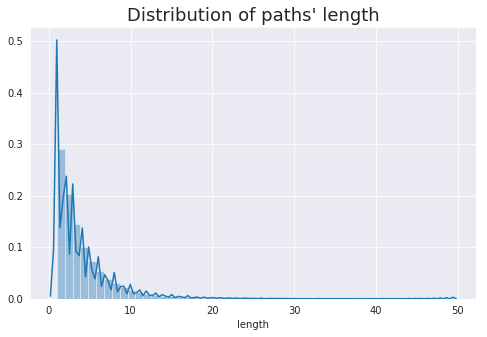

In [121]:
plt.figure(figsize=(8, 5))
sns.distplot(paths_pd.loc[paths_pd.length < 50, :].length)
plt.title("Distribution of paths' length", fontsize=18)

In [122]:
spark.sql("select terminating_event, avg(length) avg_length from ebr_test.bt_pa_postpaid_2019_paths group by 1").show(200, False)

+-----------------+-----------------+
|terminating_event|avg_length       |
+-----------------+-----------------+
|CHURN            |4.330130895194557|
|ANNEX            |3.931452711910602|
+-----------------+-----------------+



## Run PatternAnalyzer - Step 2: build transformed **Frequent Patterns**

Now, we can proceed with step 2:
* finding relatively short, repeatable patterns in calculated paths
* In the same step, we can **evaluate these patterns** by calculating statistics like: **support**, **confidence** and **lift**. 


## Submitting the command

Needed arguments are:
* -f, or --find_frequent_patterns (for finding frequent patterns in calculated paths)
* -e, or --events (input is an event table)
* -i or --input_table <table_name>
* -o or --output_table <table_name_prefix> (prefix for tables with evaluated patterns)
* -s, or --min_support (minimum support: threshold for PrefixSpan)
* -l, or --max_pattern_length (maximum pattern length: threshold for PrefixSpan)
* -t1 <terminator_1> t2 <terminator_2>
<br><br>

PatternAnalyzer will create 2 output tables per each run:
* with evaluated frequent patterns for the entire population (both churners and annexes: "ev_fp" in table name)
* and another with patterns being frequent only for churners **BUT NOT** for the whole population ("ev_to" in the table name)

Below, there are tables created by 2 runs of PatternAnalyzer:
* with parameters: -c 0.01 -l 10 (minimum support 0.01 and maximum pattern length 10)
* with parameters: -c 0.0025 -l 10 (minimum support 0.0025 and maximum pattern length 10)

The part of the tables' name marked in red refers to the <font color='red'>pattern type</font>, while part marked in the green refers to the <font color='green'>frequent pattern definition</font> like minimum support and maximum pattern length:

<img src="img/fp_to_table_names_convention.PNG">

The whole command is below:


In [124]:
%%time
! spark2-submit jar/patternAnalysis.jar -f -p -i ebr_test.bt_pa_postpaid_2019_paths -o ebr_test.bt_pa_postpaid_2019 -s 0.01 -l 10 -t1 CHURN -t2 ANNEX 2> err.txt
! spark2-submit jar/patternAnalysis.jar -f -p -i ebr_test.bt_pa_postpaid_2019_paths -o ebr_test.bt_pa_postpaid_2019 -s 0.0025 -l 10 -t1 CHURN -t2 ANNEX 2> err.txt

Password for spark@TMPL.HALO.TELEKOM-DIENSTE.DE: 
Password for spark@TMPL.HALO.TELEKOM-DIENSTE.DE: 
Spark mode is yarn
Pattern Analyzer v1.7.0
Running frequent patterns command.
NOTE: input data is in 'paths' format.
Method transform is re-using pre-calculated paths.
Transformed data frame has: 239449 total rows and 55999 target rows, target share is: 0.2339
Analyzing patterns in the entire dataset and comparing to the target subset:
Share of level 'CHURN' is 0.2338660842183513
searching for frequent patterns... OK, 1465 frequent patterns found
searching for frequent patterns... OK, 1899 frequent patterns found
Saving frequent patterns table as ebr_test.bt_pa_postpaid_2019_pa_fp_ev_s0_0025__l10... OK!
Saving target only patterns table as ebr_test.bt_pa_postpaid_2019_pa_to_ev_s0_0025__l10... OK!
Done!
CPU times: user 5.96 s, sys: 1.24 s, total: 7.2 s
Wall time: 5min 12s


In [125]:
spark.sql("show tables").show(20, False)

+--------+---------------------------------------------------------------+-----------+
|database|tableName                                                      |isTemporary|
+--------+---------------------------------------------------------------+-----------+
|ebr_test|a                                                              |false      |
|ebr_test|bt_pa_postpaid_2019_events                                     |false      |
|ebr_test|bt_pa_postpaid_2019_events_to_score                            |false      |
|ebr_test|bt_pa_postpaid_2019_model_rules__s0_0025__l10____c0_033__n0_005|false      |
|ebr_test|bt_pa_postpaid_2019_model_rules__s0_0025__l10____c0_33__n0_005 |false      |
|ebr_test|bt_pa_postpaid_2019_pa_fp_ev_s0_0025__l10                      |false      |
|ebr_test|bt_pa_postpaid_2019_pa_fp_ev_s0_01__l10                        |false      |
|ebr_test|bt_pa_postpaid_2019_pa_fp_s0_0025__l10                         |false      |
|ebr_test|bt_pa_postpaid_2019_pa_fp_s0_01__

## Discovered Frequent Patterns - **both** churners and non-churners

In [126]:
refresh_tables = ["ebr_test.bt_pa_postpaid_2019_pa_fp_ev_s0_01__l10", "ebr_test.bt_pa_postpaid_2019_pa_to_ev_s0_01__l10", "ebr_test.bt_pa_postpaid_2019_pa_fp_ev_s0_0025__l10", "ebr_test.bt_pa_postpaid_2019_pa_to_ev_s0_0025__l10"]

for t in refresh_tables:
    spark.sql("refresh table {}".format(t))

### To Pandas for easier inspection discovered frequent patterns

In [127]:
postpaid_2019_pa_fp_ev_s0_01__l10_pd = spark.sql("select * from ebr_test.bt_pa_postpaid_2019_pa_fp_ev_s0_01__l10").orderBy("confidence", ascending=False).toPandas()
postpaid_2019_pa_to_ev_s0_01__l10_pd = spark.sql("select * from ebr_test.bt_pa_postpaid_2019_pa_to_ev_s0_01__l10") .toPandas()

postpaid_2019_pa_fp_ev_s0_0025__l10_pd = spark.sql("select * from ebr_test.bt_pa_postpaid_2019_pa_fp_ev_s0_0025__l10").orderBy("confidence", ascending=False).toPandas()
postpaid_2019_pa_to_ev_s0_0025__l10_pd = spark.sql("select * from ebr_test.bt_pa_postpaid_2019_pa_to_ev_s0_0025__l10") .toPandas()

## Discovered Frequent Patterns - whole population **both** "Churners" and "Non-Churners"

In [128]:
pd.set_option('display.max_colwidth', -1)

In [129]:
postpaid_2019_pa_fp_ev_s0_01__l10_pd.sort_values("confidence", ascending=False).head(15)

frequent_pattern  \
0   [CC_SAVE_DESK:TD_RIR_0.3_0.5:SUK_KONSULTANT]                      
1   [CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, comp_call_WWW]   
2   [CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, comp_call_WWW]   
3   [comp_call_WWW, comp_call_WWW, comp_call_WWW]                     
4   [comp_call_WWW, comp_call_WWW]                                    
5   [comp_call_WWW, often_interactions2]                              
6   [bill_shocking, churn_sentence]                                   
7   [often_interactions2, OTHER:TD_RIR_UNKN:KIWI]                     
8   [often_interactions2, churn_sentence]                             
9   [comp_call_WWW]                                                   
10  [comp_call_WWW, CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT]   
11  [DEALERS:TD_RIR_0.3_0.5:FRKONSULTANT, often_interactions2]        
12  [DEALERS:TD_RIR_over_0.5:FRKONSULTANT]                            
13  [OTHER:TD_RIR_UNKN:KIWI]                                          
14  [churn_sentence]                                                  

    pattern_length  frequence  target_frequence  confidence    lift  \
0   1               3711.0     1853.0            0.4993      2.1351   
1   2               2588.0     1190.0            0.4598      1.9661   
2   2               2424.0     1084.0            0.4472      1.9122   
3   3               3354.0     1340.0            0.3995      1.7083   
4   2               5951.0     2271.0            0.3816      1.6318   
5   2               2612.0     991.0             0.3794      1.6223   
6   2               3782.0     1430.0            0.3781      1.6168   
7   2               2798.0     1034.0            0.3695      1.5802   
8   2               4666.0     1713.0            0.3671      1.5698   
9   1               11545.0    4214.0            0.3650      1.5608   
10  2               2437.0     886.0             0.3636      1.5546   
11  2               3270.0     1186.0            0.3627      1.5508   
12  1               9733.0     3524.0            0.3621      1.5482   
13  1               11143.0    3978.0            0.3570      1.5265   
14  1               16402.0    5854.0            0.3569      1.5261   

                                                               rpattern  
0   (CC_SAVE_DESK:TD_RIR_0.3_0.5:SUK_KONSULTANT).*                       
1   (CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT).*(comp_call_WWW).*  
2   (CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT).*(comp_call_WWW).*  
3   (comp_call_WWW).*(comp_call_WWW).*(comp_call_WWW).*                  
4   (comp_call_WWW).*(comp_call_WWW).*                                   
5   (comp_call_WWW).*(often_interactions2).*                             
6   (bill_shocking).*(churn_sentence).*                                  
7   (often_interactions2).*(OTHER:TD_RIR_UNKN:KIWI).*                    
8   (often_interactions2).*(churn_sentence).*                            
9   (comp_call_WWW).*                                                    
10  (comp_call_WWW).*(CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT).*  
11  (DEALERS:TD_RIR_0.3_0.5:FRKONSULTANT).*(often_interactions2).*       
12  (DEALERS:TD_RIR_over_0.5:FRKONSULTANT).*                             
13  (OTHER:TD_RIR_UNKN:KIWI).*                                           
14  (churn_sentence).*

## After some tuning (confidence and pattern length are hyperparameters): confidence is much better

In [130]:
postpaid_2019_pa_fp_ev_s0_0025__l10_pd.sort_values("confidence", ascending=False).head(30)

frequent_pattern  \
0   [POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY]                                                                                     
1   [CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, POACH_WWW_USAGE_PLAY]                                                           
2   [POACH_WWW_USAGE_PLAY]                                                                                                           
3   [CC_SAVE_DESK:TD_RIR_0.3_0.5:SUK_KONSULTANT, churn_sentence]                                                                     
4   [CC_SAVE_DESK:TD_RIR_over_0.5:SUK_KONSULTANT]                                                                                    
5   [DEALERS:TD_RIR_0.3_0.5:FRKONSULTANT, OTHER:TD_RIR_UNKN:KIWI]                                                                    
6   [DEALERS:TD_RIR_0.3_0.5:FRKONSULTANT, churn_sentence]                                                                            
7   [CC_SAVE_DESK:TD_RIR_0.3_0.5:SUK_KONSULTANT, often_interactions2]                                                                
8   [churn_sentence, comp_call_WWW]                                                                                                  
9   [CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, comp_call_WWW, comp_call_WWW, comp_call_WWW]                                    
10  [CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, comp_call_WWW, comp_call_WWW, comp_call_WWW]                                    
11  [CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, comp_call_WWW, comp_call_WWW]                                                   
12  [CC_SAVE_DESK:TD_RIR_0.3_0.5:SUK_KONSULTANT]                                                                                     
13  [UNKNOWN:TD_RIR_0.3_0.5:ADMIN, churn_sentence]                                                                                   
14  [comp_call_WWW, CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, comp_call_WWW]                                                   
15  [bill_shocking, CC_SAVE_DESK:TD_RIR_0.3_0.5:SUK_KONSULTANT]                                                                      
16  [CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, comp_call_WWW, comp_call_WWW]   
17  [CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, comp_call_WWW, comp_call_WWW]                                                   
18  [OTHER:TD_RIR_UNKN:KIWI, churn_sentence]                                                                                         
19  [often_interactions2, CC_SAVE_DESK:TD_RIR_0.3_0.5:SUK_KONSULTANT]                                                                
20  [often_interactions2, comp_call_WWW, comp_call_WWW]                                                                              
21  [DEALERS:TD_RIR_0.0_0.3:FRKONSULTANT, churn_sentence]                                                                            
22  [OTHER:TD_RIR_UNKN:KIWI, DEALERS:TD_RIR_0.3_0.5:FRKONSULTANT]                                                                    
23  [CC_SAVE_DESK:TD_RIR_over_0.5:HOTLINE_KONSULTANT]                                                                                
24  [REKLAMACJA_START_REKLAMACJA]                                                                                                    
25  [CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, CC_SAVE_DESK:TD_RIR_0.3_0.5:SUK_KONSULTANT]                                     
26  [CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, comp_call_WWW]                                                                  
27  [often_interactions2, often_interactions2, comp_call_WWW]                                                                        
28  [bills_nonpayer, UNKNOWN:TD_RIR_0.3_0.5:ADMIN]                                                                                   
29  [CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, often_interactions2, comp_call_WWW]      

## Discovered Frequent Patterns - **only CHURNERS population**

In [131]:
postpaid_2019_pa_to_ev_s0_01__l10_pd.sort_values("confidence", ascending=False).head(15)

frequent_pattern  \
48  [POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY]                                     
60  [POACH_WWW_USAGE_PLAY]                                                           
32  [CC_SAVE_DESK:TD_RIR_0.3_0.5:SUK_KONSULTANT, churn_sentence]                     
46  [CC_SAVE_DESK:TD_RIR_over_0.5:SUK_KONSULTANT]                                    
39  [DEALERS:TD_RIR_0.3_0.5:FRKONSULTANT, churn_sentence]                            
17  [CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, comp_call_WWW, comp_call_WWW]   
18  [CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, comp_call_WWW, comp_call_WWW]   
53  [often_interactions2, comp_call_WWW]                                             
27  [comp_call_WWW, comp_call_WWW, comp_call_WWW, comp_call_WWW, comp_call_WWW]      
43  [CC_SAVE_DESK:TD_RIR_0.3_0.5:HOTLINE_KONSULTANT]                                 
47  [CC_SAVE_DESK:TD_RIR_0.0_0.3:SUK_KONSULTANT]                                     
38  [comp_call_WWW, comp_call_WWW, comp_call_WWW, comp_call_WWW]                     
56  [churn_sentence, churn_sentence]                                                 
57  [bill_shocking, comp_call_WWW]                                                   
21  [CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, OTHER:TD_RIR_UNKN:KIWI]         

    pattern_length  target_frequence  \
48  2               647                
60  1               1366               
32  2               576                
46  1               991                
39  2               704                
17  3               686                
18  3               576                
53  2               899                
27  5               585                
43  1               863                
47  1               855                
38  4               873                
56  2               1002               
57  2               869                
21  2               578                

                                                                                 rpattern  \
48  (POACH_WWW_USAGE_PLAY).*(POACH_WWW_USAGE_PLAY).*                                        
60  (POACH_WWW_USAGE_PLAY).*                                                                
32  (CC_SAVE_DESK:TD_RIR_0.3_0.5:SUK_KONSULTANT).*(churn_sentence).*                        
46  (CC_SAVE_DESK:TD_RIR_over_0.5:SUK_KONSULTANT).*                                         
39  (DEALERS:TD_RIR_0.3_0.5:FRKONSULTANT).*(churn_sentence).*                               
17  (CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT).*(comp_call_WWW).*(comp_call_WWW).*    
18  (CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT).*(comp_call_WWW).*(comp_call_WWW).*    
53  (often_interactions2).*(comp_call_WWW).*                                                
27  (comp_call_WWW).*(comp_call_WWW).*(comp_call_WWW).*(comp_call_WWW).*(comp_call_WWW).*   
43  (CC_SAVE_DESK:TD_RIR_0.3_0.5:HOTLINE_KONSULTANT).*                                      
47  (CC_SAVE_DESK:TD_RIR_0.0_0.3:SUK_KONSULTANT).*                                          
38  (comp_call_WWW).*(comp_call_WWW).*(comp_call_WWW).*(comp_call_WWW).*                    
56  (churn_sentence).*(churn_sentence).*                                                    
57  (bill_shocking).*(comp_call_WWW).*                                                      
21  (CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT).*(OTHER:TD_RIR_UNKN:KIWI).*            

    frequence  confidence      lift   support  target_support  
48  823        0.786148    3.361532  0.003437  0.011554        
60  1902       0.718191    3.070951  0.007943  0.024393        
32  872        0.660550    2.824482  0.003642  0.010286        
46  1744       0.568234    2.429741  0.007283  0.017697        
39  1337       0.526552    2.251511  0.005584  0.012572        
17  1401       0.489650    2.093721  0.005851  0.012250        
18  1194       0.482412    2.062771  0.004986  0.010286        
53  1998       0.449950    1.923964  0.008344  

## After tuning confidence is better but support is lower: I would recommend to always confirm TO patterns with business / domain experts

In [132]:
postpaid_2019_pa_to_ev_s0_0025__l10_pd.sort_values("confidence", ascending=False).head(30)

frequent_pattern  \
454  [POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY]                                                       
455  [bill_shocking, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY]                                                              
456  [CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY]                             
420  [often_interactions2, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY]                                                        
421  [CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY]                             
422  [bill_shocking, POACH_WWW_USAGE_PLAY]                                                                                    
465  [POACH_WWW_USAGE_PLAY, comp_call_WWW]                                                                                    
466  [often_interactions2, POACH_WWW_USAGE_PLAY]                                                                              
467  [CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, often_interactions2, POACH_WWW_USAGE_PLAY]                              
542  [CC_SAVE_DESK:TD_RIR_over_0.5:SUK_KONSULTANT, churn_sentence]                                                            
543  [churn_sentence, POACH_WWW_USAGE_PLAY]                                                                                   
544  [CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, POACH_WWW_USAGE_PLAY]   
483  [comp_call_WWW, POACH_WWW_USAGE_PLAY]                                                                                    
484  [CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, POACH_WWW_USAGE_PLAY]                                                   
485  [often_interactions2, often_interactions2, POACH_WWW_USAGE_PLAY]                                                         
310  [CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, often_interactions2, POACH_WWW_USAGE_PLAY]                              
311  [CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, POACH_WWW_USAGE_PLAY]   
518  [POACH_WWW_USAGE_PLAY, bill_shocking]                                                                                    
519  [atg_visit, POACH_WWW_USAGE_PLAY]                                                                                        
520  [DEALERS:TD_RIR_over_0.5:FRKONSULTANT, CC_SAVE_DESK:TD_RIR_0.3_0.5:SUK_KONSULTANT]                                       
468  [DEALERS:TD_RIR_over_0.5:FRKONSULTANT, OTHER:TD_RIR_UNKN:KIWI]                                                           
469  [DEALERS:TD_RIR_0.0_0.3:FRKONSULTANT, CC_SAVE_DESK:TD_RIR_0.3_0.5:SUK_KONSULTANT]                                        
470  [DEALERS:TD_RIR_0.3_0.5:FRKONSULTANT, CC_SAVE_DESK:TD_RIR_0.3_0.5:SUK_KONSULTANT]                                        
448  [POACH_WWW_USAGE_PLAY, often_interactions2]                                                                              
449  [POACH_WWW_USAGE_PLAY, CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT]                                                   
450  [DEALERS:TD_RIR_0.3_0.5:FRKONSULTANT, CC_SAVE_DESK:TD_RIR_over_0.5:SUK_KONSULTANT]                                       
506  [CC_SAVE_DESK:TD_RIR_0.3_0.5:SUK_KONSULTANT, churn_sentence, often_interactions2]                                        
507  [churn_sentence, OTHER:TD_RIR_UNKN:KIWI]                                                                                 
508  [CC_SAVE_DESK:TD_RIR_over_0.5:HOTLINE_KONSULTANT, churn_sentence]                                                        
545  [POACH_WWW_USAGE_PLAY, CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT]                                                   

     pattern_length  target_frequence  \
454  3               298                
455  3               140                
456  3               220                
420  

### Some comments for frequent pattern mining part:

* The more detailed events are, the more accurate results we can get from PatternAnalyzer
* Both steps: **transformation** from events to paths and **finding frequent patterns** are very fast with PatternAnalyzer and usually take about 2 minutes each (1.4 mio of events for EBR Postpaid Priv)
* The result of **transform command** of PatternAnalyzer are paths (one row per each cont_id) - they contain all (bath relevant and not relevant) events of for a given customer / cont_id
* The result of **find frequent patterns command** of PatternAnalyzer are patterns - they contain only relevant, repeatable patterns in paths, but a single row is no longer a property of single customer / cont_id. A given customer's path can match more than one frequent pattern!


## Interactive mode

$ spark2-shell <br>
> :require patternAnalysis.jar <br>
> import bt.halo.utils.patternAnalysis.PatternAnalyzer <br>

> val pa = new PatternAnalyzer(spark.sqlContext, spark.sql("select * from ebr_test.bt_pa_postpaid_paths"), inputForm = "paths", mode = "discovery", terminators = Array("CHURN", "ANNEX"), modeledLevel = "CHURN")<br>

> pa.evaluatePatternMatch("(often_interactions2).\*(often_interactions2).\*(often_interactions2).\*(OTHER:TD_RIR_UNKN:KIWI).\*")<br>


<img src="img/screen1.PNG">

## Some visualizations of discovered frequent patterns - Entire Population

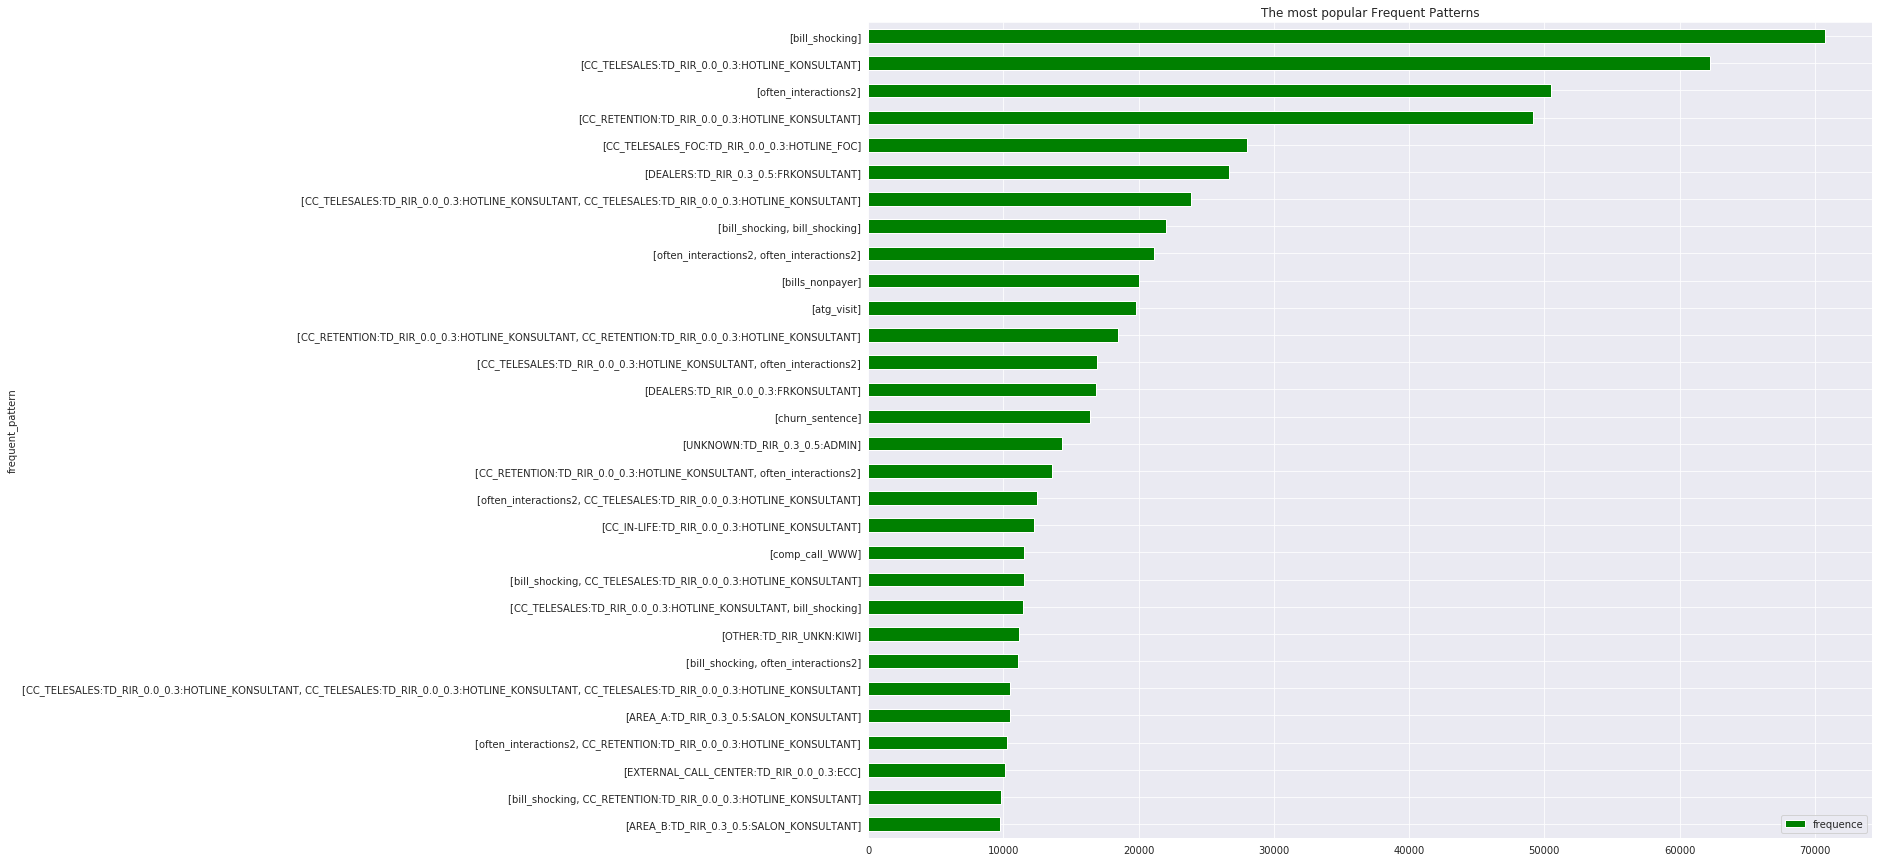

In [133]:
(
    postpaid_2019_pa_fp_ev_s0_0025__l10_pd[postpaid_2019_pa_fp_ev_s0_0025__l10_pd.target_frequence > 0]
        .sort_values("frequence", ascending=False)
        .iloc[:30, :]
        .sort_values("frequence")
        .plot.barh("frequent_pattern", "frequence", figsize=(18, 15), title="The most popular Frequent Patterns", color="green")
)

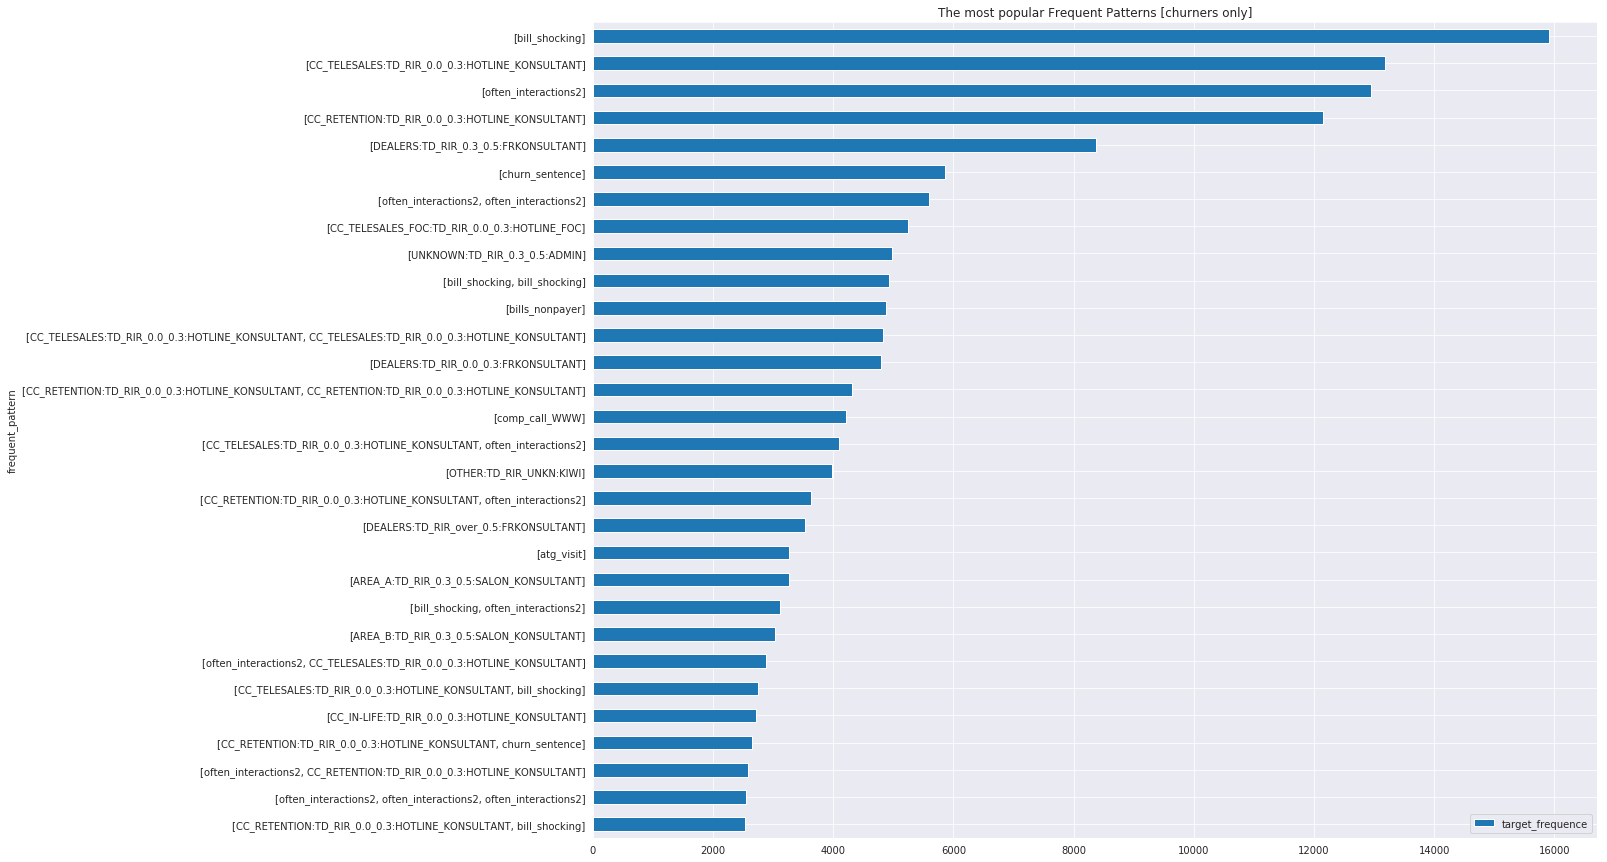

In [134]:
(
    postpaid_2019_pa_fp_ev_s0_0025__l10_pd[postpaid_2019_pa_fp_ev_s0_0025__l10_pd.target_frequence > 0]
        .sort_values("target_frequence", ascending=False)
        .iloc[:30, :]
        .sort_values("target_frequence")
        .plot.barh("frequent_pattern", "target_frequence", figsize=(18, 15), title="The most popular Frequent Patterns [churners only]")
)

In [135]:
(
    postpaid_2019_pa_fp_ev_s0_0025__l10_pd
        .sort_values("confidence", ascending=False).iloc[:30, :]
        .sort_values("confidence")
        .plot.barh("frequent_pattern", "confidence", figsize=(18, 15), color="brown", title="Frequent Patterns with highest confidence")
)

## Some visualizations of discovered frequent patterns - patterns frequent ONLY among churners' population

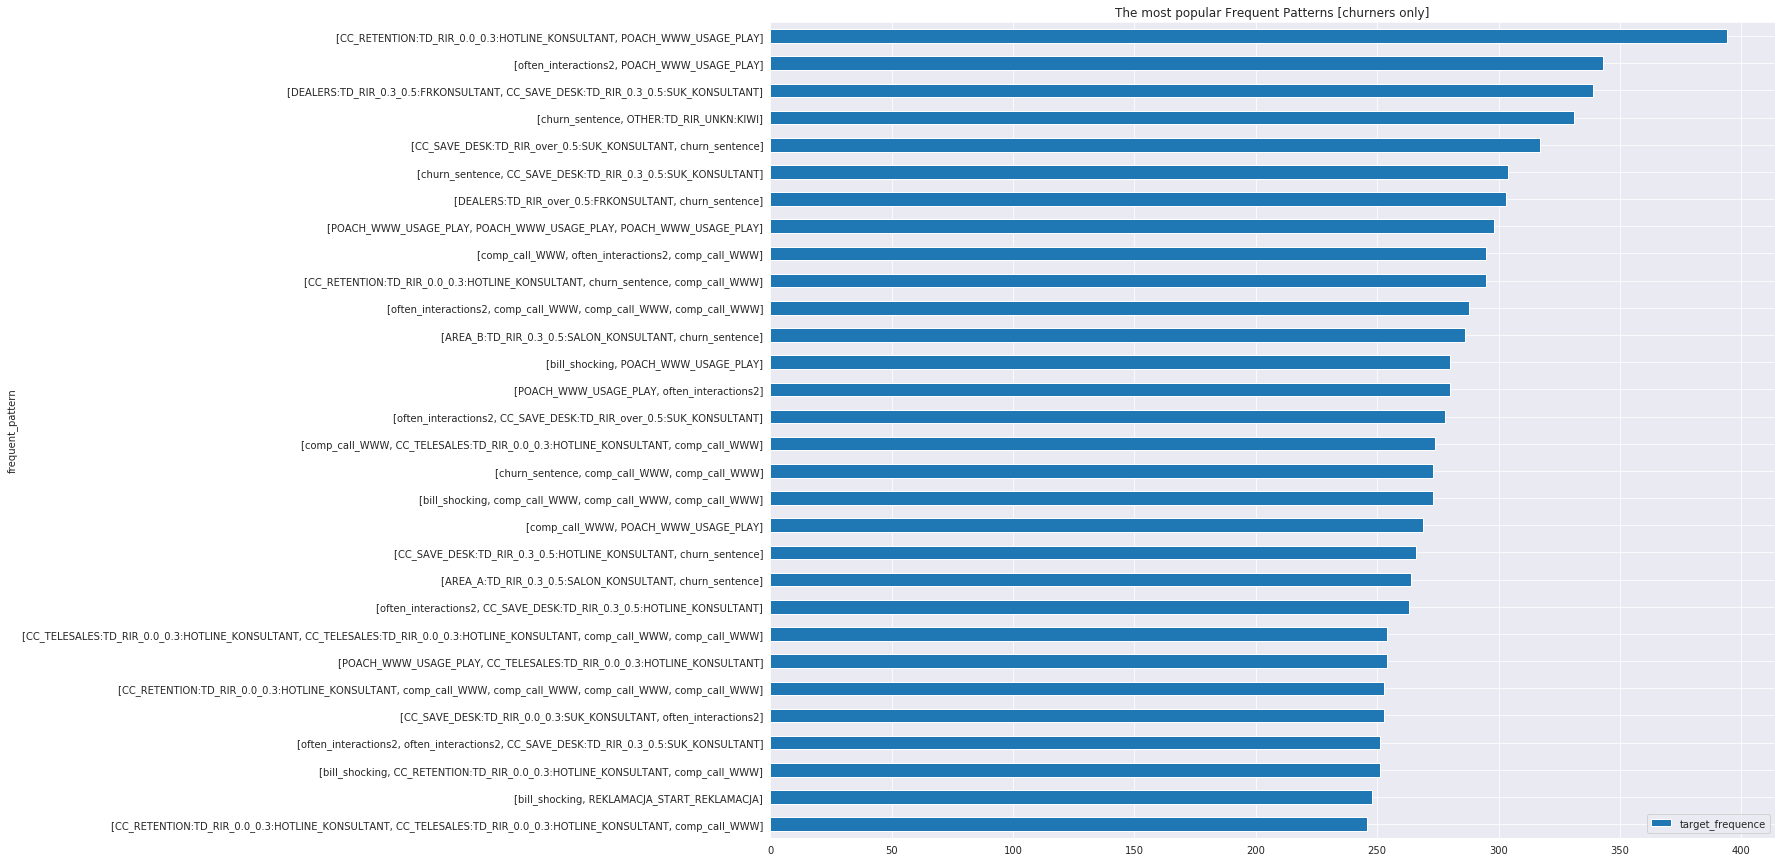

In [136]:
(
    postpaid_2019_pa_to_ev_s0_0025__l10_pd[postpaid_2019_pa_to_ev_s0_0025__l10_pd.target_frequence > 0]
        .sort_values("target_frequence", ascending=False)
        .iloc[:30, :]
        .sort_values("target_frequence")
        .plot.barh("frequent_pattern", "target_frequence", figsize=(18, 15), title="The most popular Frequent Patterns [churners only]")
)

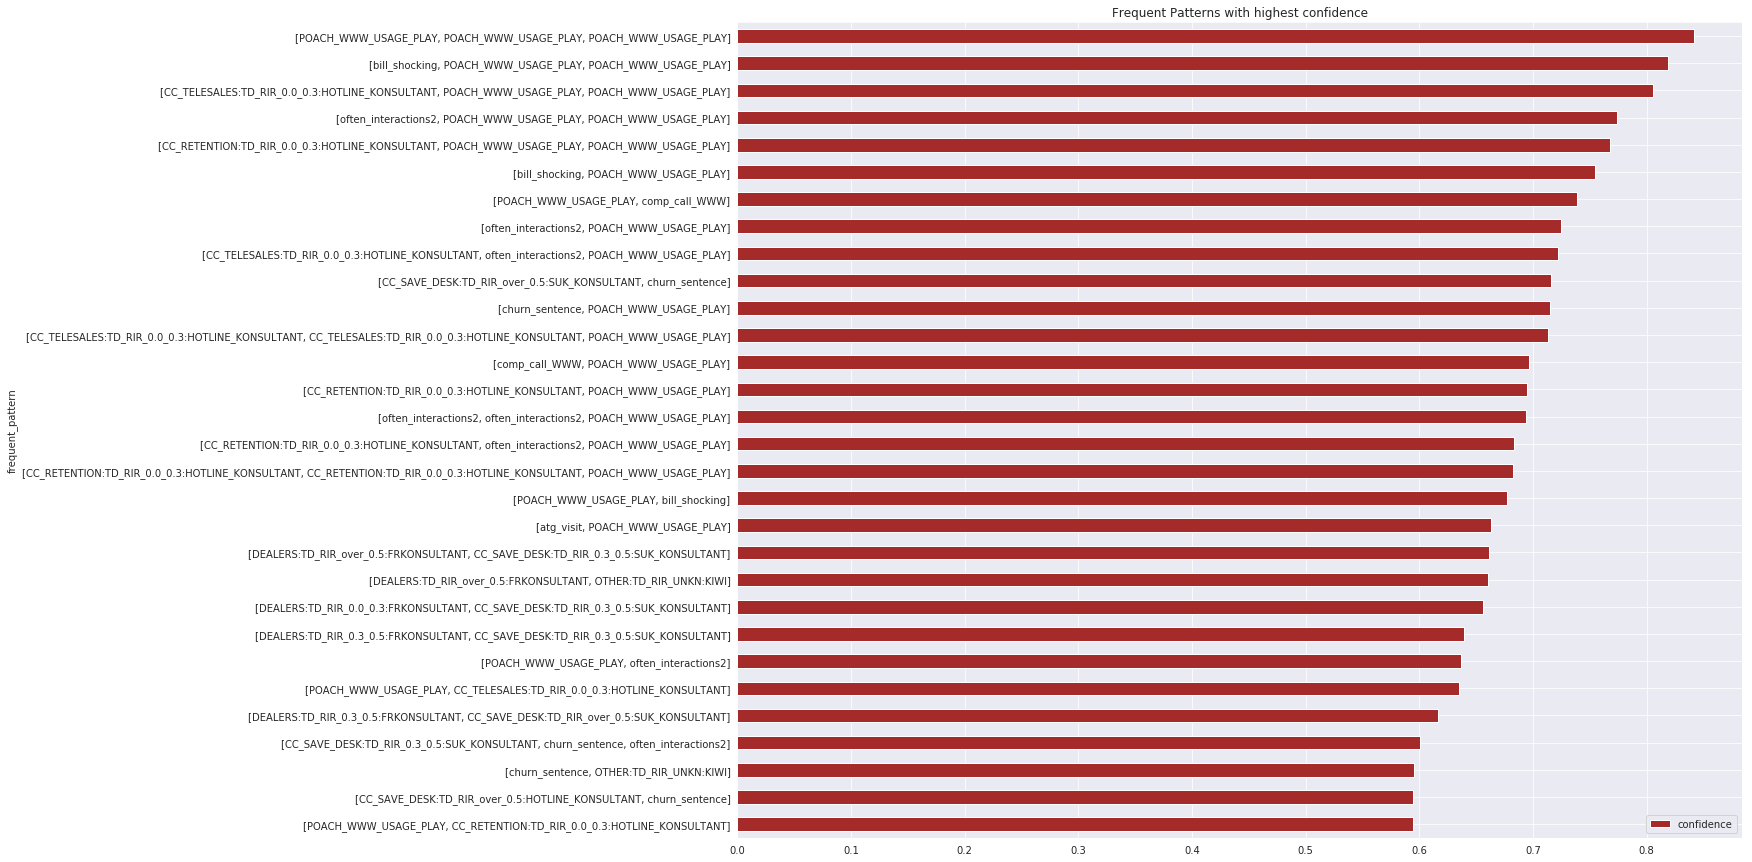

In [137]:
(
    postpaid_2019_pa_to_ev_s0_0025__l10_pd
        .sort_values("confidence", ascending=False).iloc[:30, :]
        .sort_values("confidence")
        .plot.barh("frequent_pattern", "confidence", figsize=(18, 15), color="brown", title="Frequent Patterns with highest confidence")
)

## Run PatternAnalyzer - Step 3: build **model / rules** with discovered patterns

Now, we can proceed with step 3:
* Once FP and TO patterns are being evaluated and hyperparameters tuned (minimum support, maximum pattern length), we can use them for creating a table with scoring rules for future use
* To create model, we need to use additional parameters with -f (or --find_frequent_patterns) command:
    * -m, or --create_model (which creates table with rules for scoring)
    * -c, or --min_frequent_pattern_confidence (minimum confidence to let the rule being used for scoring, in EBR we focus only on the top highest rules for event based treatment)
    * -n, or --min_target_support (minimum confidence to let the rule being used for scoring, in EBR we focus only on the top highest rules for event based treatment)


## Submitting the command

The full list of needed arguments is as below:
* -f, or --find_frequent_patterns (for finding frequent patterns in calculated paths)
* -e, or --events (input is an event table)
* -i or --input_table <table_name>
* -o or --output_table <table_name_prefix> (prefix for tables with evaluated patterns)
* -s, or --min_support (minimum support: threshold for PrefixSpan)
* -l, or --max_pattern_length (maximum pattern length: threshold for PrefixSpan)
* -t1 <terminator_1> t2 <terminator_2>
* -m, or --create_model (which creates table with rules for scoring)
* -c, or --min_frequent_pattern_confidence (minimum confidence to let the rule being used for scoring, in EBR we focus only on the top highest rules for event based treatment)
* -n, or --min_target_support (minimum confidence to let the rule being used for scoring, in EBR we focus only on the top highest rules for event based treatment)
<br><br>

PatternAnalyzer will create one additional table with model / rules for future scoring.<br>
Similarly like the last time, table name marked in blue refers to selected options for model/rules creation: <font color="royalblue">minimum confidence</font> and <font color="royalblue">minimum support in target population</font>.<br>
PatternAnalyzer was invoked twice so 2 models were built for confidence = 0.33 and confidence = 0.033, minimum target support was defined as 0.005 in both cases:<br><br>


<img src="img/model_rules_table_name_convention.PNG">

The whole command is below:


In [138]:
%%time
! spark2-submit jar/patternAnalysis.jar -f -p -i ebr_test.bt_pa_postpaid_2019_paths -o ebr_test.bt_pa_postpaid_2019 -s 0.0025 -l 10 -m -c 0.33 -n 0.005 -t1 CHURN -t2 ANNEX 2> err.txt

Password for spark@TMPL.HALO.TELEKOM-DIENSTE.DE: 
Password for spark@TMPL.HALO.TELEKOM-DIENSTE.DE: 
Spark mode is yarn
Pattern Analyzer v1.7.0
Running frequent patterns command.
NOTE: input data is in 'paths' format.
Method transform is re-using pre-calculated paths.
Transformed data frame has: 239449 total rows and 55999 target rows, target share is: 0.2339
Analyzing patterns in the entire dataset and comparing to the target subset:
Share of level 'CHURN' is 0.2338660842183513
searching for frequent patterns... OK, 1465 frequent patterns found
searching for frequent patterns... OK, 1899 frequent patterns found
Saving frequent patterns table as ebr_test.bt_pa_postpaid_2019_pa_fp_ev_s0_0025__l10... OK!
Saving target only patterns table as ebr_test.bt_pa_postpaid_2019_pa_to_ev_s0_0025__l10... OK!
Saving model rules table as ebr_test.bt_pa_postpaid_2019_model_rules__s0_0025__l10____c0_33__n0_005... OK!
Done!
CPU times: user 7.02 s, sys: 1.44 s, total: 8.46 s
Wall time: 6min 7s


### New table with new model / rules created by PatternAnalyzer can be accessed as a Hive table

In [153]:
spark.sql("show tables").show(5, False)

+--------+---------------------------------------------------------------+-----------+
|database|tableName                                                      |isTemporary|
+--------+---------------------------------------------------------------+-----------+
|ebr_test|a                                                              |false      |
|ebr_test|bt_pa_postpaid_2019_events                                     |false      |
|ebr_test|bt_pa_postpaid_2019_events_to_score                            |false      |
|ebr_test|bt_pa_postpaid_2019_model_rules__s0_0025__l10____c0_033__n0_005|false      |
|ebr_test|bt_pa_postpaid_2019_model_rules__s0_0025__l10____c0_33__n0_005 |false      |
+--------+---------------------------------------------------------------+-----------+
only showing top 5 rows



In [154]:
spark.sql("refresh table ebr_test.bt_pa_postpaid_2019_pa_to_ev_s0_0025__l10")
spark.sql("refresh table ebr_test.bt_pa_postpaid_2019_model_rules__s0_0025__l10____c0_33__n0_005")
spark.sql("select * from ebr_test.bt_pa_postpaid_2019_pa_to_ev_s0_0025__l10 order by confidence desc limit 20").show()

+--------------------+--------------+----------------+--------------------+---------+------------------+------------------+--------------------+--------------------+
|    frequent_pattern|pattern_length|target_frequence|            rpattern|frequence|        confidence|              lift|             support|      target_support|
+--------------------+--------------+----------------+--------------------+---------+------------------+------------------+--------------------+--------------------+
|[POACH_WWW_USAGE_...|             3|             298|(POACH_WWW_USAGE_...|      354|0.8418079096045198|3.5995296727958115|0.001478394146561...|0.005321523598635...|
|[bill_shocking, P...|             3|             140|(bill_shocking).*...|      171|0.8187134502923976| 3.500778888177723|7.141395453729186E-4|0.002500044643654351|
|[CC_TELESALES:TD_...|             3|             220|(CC_TELESALES:TD_...|      273|0.8058608058608059| 3.445821605788748|0.001140117519805...|0.003928641582885408|
|[of

In [155]:
spark.sql("select count(*) ile_target_only_patterns from ebr_test.bt_pa_postpaid_2019_pa_to_ev_s0_0025__l10").show()

+------------------------+
|ile_target_only_patterns|
+------------------------+
|                     562|
+------------------------+



### Rules can be analyzed similarly like paths and patterns before

In [156]:
model_rules_pd = spark.sql("select * from bt_pa_postpaid_2019_model_rules__s0_0025__l10____c0_33__n0_005 order by confidence desc").drop("rpattern").toPandas()

In [157]:
pd.set_option('display.max_colwidth', -1)
model_rules_pd.sort_values("confidence", ascending=False).head(20)

pattern  \
0   [POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY]                  
1   [POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY]                                        
2   [bill_shocking, POACH_WWW_USAGE_PLAY]                                               
3   [CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, POACH_WWW_USAGE_PLAY]              
4   [often_interactions2, POACH_WWW_USAGE_PLAY]                                         
5   [POACH_WWW_USAGE_PLAY]                                                              
6   [CC_SAVE_DESK:TD_RIR_over_0.5:SUK_KONSULTANT, churn_sentence]                       
7   [CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, POACH_WWW_USAGE_PLAY]              
8   [CC_SAVE_DESK:TD_RIR_0.3_0.5:SUK_KONSULTANT, churn_sentence]                        
9   [DEALERS:TD_RIR_0.3_0.5:FRKONSULTANT, CC_SAVE_DESK:TD_RIR_0.3_0.5:SUK_KONSULTANT]   
10  [POACH_WWW_USAGE_PLAY, often_interactions2]                                         
11  [churn_sentence, OTHER:TD_RIR_UNKN:KIWI]                                            
12  [DEALERS:TD_RIR_over_0.5:FRKONSULTANT, churn_sentence]                              
13  [CC_SAVE_DESK:TD_RIR_over_0.5:SUK_KONSULTANT]                                       
14  [DEALERS:TD_RIR_0.3_0.5:FRKONSULTANT, OTHER:TD_RIR_UNKN:KIWI]                       
15  [DEALERS:TD_RIR_0.3_0.5:FRKONSULTANT, churn_sentence]                               
16  [AREA_B:TD_RIR_0.3_0.5:SALON_KONSULTANT, churn_sentence]                            
17  [CC_SAVE_DESK:TD_RIR_0.3_0.5:SUK_KONSULTANT, often_interactions2]                   
18  [churn_sentence, CC_SAVE_DESK:TD_RIR_0.3_0.5:SUK_KONSULTANT]                        
19  [churn_sentence, comp_call_WWW]                                                     

    pattern_length  frequence   support  confidence      lift pattern_type  
0   3               354        0.001478  0.841808    3.599530  TO           
1   2               823        0.003437  0.786100    3.361500  FP           
2   2               371        0.001549  0.754717    3.227133  TO           
3   2               626        0.002614  0.730000    3.121600  FP           
4   2               473        0.001975  0.725159    3.100743  TO           
5   1               1902       0.007943  0.718200    3.071000  FP           
6   2               443        0.001850  0.715576    3.059767  TO           
7   2               567        0.002368  0.694885    2.971296  TO           
8   2               872        0.003642  0.660600    2.824500  FP           
9   2               530        0.002213  0.639623    2.734995  TO           
10  2               440        0.001838  0.636364    2.721060  TO           
11  2               556        0.002322  0.595324    2.545575  TO           
12  2               512        0.002138  0.591797    2.530495  TO           
13  1               1744       0.007283  0.568200    2.429700  FP           
14  2               697        0.002911  0.532300    2.276000  FP           
15  2               1337       0.005584  0.526600    2.251500  FP           
16  2               554        0.002314  0.516245    2.207441  TO           
17  2               1021       0.004264  0.516200    2.207100  FP           
18  2               591        0.002468  0.514382    2.199474  TO           
19  2               930        0.003884  0.512900    2.193100  FP

### FP/TO summary

In [158]:
model_rules_pd.groupby("pattern_type").count().iloc[:, :1]

pattern
pattern_type         
FP            237    
TO            14

In [159]:
model_rules_pd.groupby("pattern_type").mean()

pattern_length    frequence   support  confidence      lift
pattern_type                                                             
FP            2.637131        1517.624473  0.006338  0.391516    1.674111
TO            2.357143        510.357143   0.002131  0.623426    2.665741

## Scoring

Having evaluated patterns available as a model/rules saved as a Hive table, we can use it for scoring new "paths" (sequences of events) in a new/scoring data:<br>

In [160]:
spark.sql("drop table if exists ebr_test.bt_pa_postpaid_2019_events_to_score")
spark.sql("create table ebr_test.bt_pa_postpaid_2019_events_to_score as select * from ebr_test.bt_pa_postpaid_2019_events where event not in ('ANNEX', 'CHURN')")
spark.sql("refresh table ebr_test.bt_pa_postpaid_2019_events_to_score")

DataFrame[]

In [161]:
spark.sql("show tables").show(5, False)

+--------+---------------------------------------------------------------+-----------+
|database|tableName                                                      |isTemporary|
+--------+---------------------------------------------------------------+-----------+
|ebr_test|a                                                              |false      |
|ebr_test|bt_pa_postpaid_2019_events                                     |false      |
|ebr_test|bt_pa_postpaid_2019_events_to_score                            |false      |
|ebr_test|bt_pa_postpaid_2019_model_rules__s0_0025__l10____c0_033__n0_005|false      |
|ebr_test|bt_pa_postpaid_2019_model_rules__s0_0025__l10____c0_33__n0_005 |false      |
+--------+---------------------------------------------------------------+-----------+
only showing top 5 rows



## Run PatternAnalyzer - Step 4: use built model / detected patterns to score new datasets

Once the model / scoring rules are available, we can use them for scoring the new dataset to assign probability based on detected patterns in their event paths.<br>
To score a new dataset using PatternAnalyzer, we need to use -x (or --score) command with similar options like we used for transform command:
* -e, --events (input table is an event table, default) or -p, --paths (input table is a path table)
* -i, --input_table <hive_schema.hive_table>
* -o, --output_table <hive_schema.hive_table>
* -a, --real_target_share (optional: target share in real population)
* -m, --model_rules  <hive_schema.hive_table>


The whole command is below:


In [162]:
%%time
! spark2-submit jar/patternAnalysis.jar -x -e -i ebr_test.bt_pa_postpaid_2019_events_to_score -o ebr_test.bt_pa_postpaid_2019 -m ebr_test.bt_pa_postpaid_2019_model_rules__s0_0025__l10____c0_033__n0_005 -a 0.2339 2> err.txt

Password for spark@TMPL.HALO.TELEKOM-DIENSTE.DE: 
Password for spark@TMPL.HALO.TELEKOM-DIENSTE.DE: 
Spark mode is yarn
Pattern Analyzer v1.7.0
Running scoring command.
NOTE: input data is in 'events' format.
Mode: scoring
Preparing data for sequence analysis... OK, 1203157 rows processed.
Transformed data frame has: 239449 total rows and 239449 target rows, target share is: 0.2339
Scoring with "full" method
Results saved as ebr_test.bt_pa_postpaid_2019_scored table.
Done!
CPU times: user 5.62 s, sys: 1.32 s, total: 6.94 s
Wall time: 5min


In [163]:
spark.sql("refresh table bt_pa_postpaid_2019_scored")

DataFrame[]

In [164]:
spark.sql("show tables").show(15, False)

+--------+---------------------------------------------------------------+-----------+
|database|tableName                                                      |isTemporary|
+--------+---------------------------------------------------------------+-----------+
|ebr_test|a                                                              |false      |
|ebr_test|bt_pa_postpaid_2019_events                                     |false      |
|ebr_test|bt_pa_postpaid_2019_events_to_score                            |false      |
|ebr_test|bt_pa_postpaid_2019_model_rules__s0_0025__l10____c0_033__n0_005|false      |
|ebr_test|bt_pa_postpaid_2019_model_rules__s0_0025__l10____c0_33__n0_005 |false      |
|ebr_test|bt_pa_postpaid_2019_pa_fp_ev_s0_0025__l10                      |false      |
|ebr_test|bt_pa_postpaid_2019_pa_fp_ev_s0_01__l10                        |false      |
|ebr_test|bt_pa_postpaid_2019_pa_fp_s0_0025__l10                         |false      |
|ebr_test|bt_pa_postpaid_2019_pa_fp_s0_01__

In [165]:
spark.sql("select * from bt_pa_postpaid_2019_scored order by score desc limit 25").show()

+---------+--------------------+------+------------------+------------------+----------------+
|       id|          event_path|length|             score|     expected_lift|patterns_matched|
+---------+--------------------+------+------------------+------------------+----------------+
| 73297597|[CC_RETENTION:TD_...|     6|0.8418079096045198|3.6070309165125325|               1|
| 35313620|[EXTERNAL_CALL_CE...|     4|0.8418079096045198|3.6070309165125325|               1|
|142524174|[atg_visit, POACH...|     5|0.8418079096045198|3.6070309165125325|               1|
| 76447322|[POACH_WWW_USAGE_...|     7|0.8418079096045198|3.6070309165125325|               1|
| 27742561|[POACH_WWW_USAGE_...|     3|0.8418079096045198|3.6070309165125325|               1|
|142310324|[POACH_WWW_USAGE_...|     3|0.8418079096045198|3.6070309165125325|               1|
|143677284|[bill_shocking, D...|     5|0.8418079096045198|3.6070309165125325|               1|
|142585179|[POACH_WWW_USAGE_...|     3|0.841807909

In [166]:
spark.sql("select count(*) ile, min(score) min_score, max(score) max_score from bt_pa_postpaid_2019_scored").show()

+------+---------+------------------+
|   ile|min_score|         max_score|
+------+---------+------------------+
|237355|    0.106|0.8418079096045198|
+------+---------+------------------+



### Score analysis

In [167]:
# scored_pd = spark.sql("select s.*, decision, case when decision = 'ANNEX' then 0 else 1 end churn from ebr_test.bt_pa_postpaid_2019_scored s join ebr_test.mdl_postpaid_new_pop d on d.cont_id = s.id order by score desc").toPandas()

In [168]:
decision_df = spark.sql("select cont_id, decision, case when decision = 'ANNEX' then 0 else 1 end churn from ebr_test.mdl_postpaid_new_pop")
scored_df1 = spark.sql("select s.* from ebr_test.bt_pa_postpaid_2019_scored s")
scored_df = scored_df1.join(decision_df, scored_df1.id == decision_df.cont_id)

scored_pd = scored_df.toPandas()

In [177]:
scored_pd.sort_values("score", ascending=False).head(20)

id  \
109804  112870744   
234858  144672512   
89363   96648312    
68650   85850854    
163237  143865654   
14861   40982657    
11234   36665044    
27507   33456449    
194429  143830817   
200984  156430553   
27730   32371012    
234839  143789107   
230369  144095448   
4042    22842172    
217407  142323845   
64822   68993645    
33220   35022001    
140133  141708458   
83584   71282990    
88964   100174019   

                                                                                                                                                                                                                                                                                                                                            event_path  \
109804  [POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY]                                                                                                                                                                                                                                                         
234858  [bill_shocking, CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, POACH_WWW_USAGE_PLAY, comp_call_WWW, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY]                                                                                                                                                                           
89363   [OTHER:TD_RIR_UNKN:KIWI, OTHER:TD_RIR_UNKN:KIWI, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY]                                                                                                                                                             
68650   [POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY]                                                                                                                                                                                                                                                         
163237  [atg_visit, E-SHOP_FTE:TD_RIR_0.0_0.3:S_KORESP_ST_KONSULTANT, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY]                                                                                                                                                                                            
14861   [CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY]                                                                                                                                                                                                         
11234   [AREA_A:TD_RIR_over_0.5:SALON_KONSULTANT, POACH_WWW_USAGE_PLAY, AREA_A:TD_RIR_over_0.5:SALON_KONSULTANT, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT]                                                                                                                                             
27507   [comp_call_WWW, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY]                                                                                                                                                                                                                                                                
194429  [bills_nonpayer, POACH_WWW_USAGE_ORANGE, OTHER:TD_RIR_UNKN:KIWI, CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, Aplikacja Mój T-Mobile:TD_RIR_UNKN:ONE_APP, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY]                       
200984  [POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, POACH_WWW_USAGE_PLAY, CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KO

Text(0.5, 1.0, 'Distribution of score')

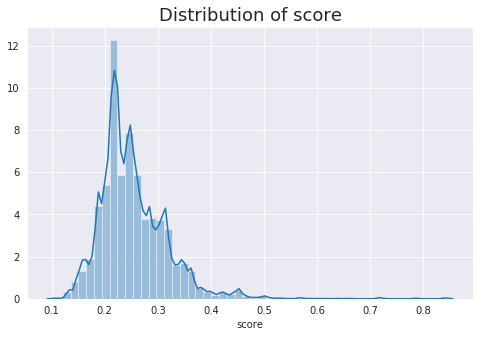

In [170]:
plt.figure(figsize=(8, 5))
sns.distplot(scored_pd.score)
plt.title("Distribution of score", fontsize=18)

Text(0.5, 1.0, 'Distribution of score')

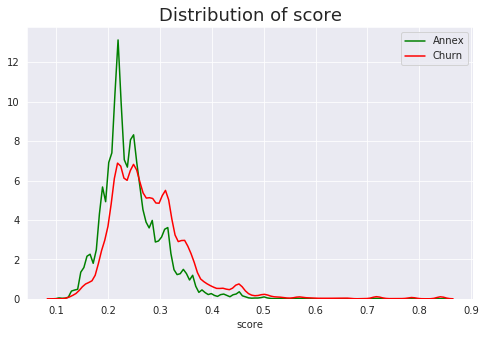

In [171]:
plt.figure(figsize=(8, 5))
sns.distplot(scored_pd.loc[scored_pd.churn == 0].score, color="g", hist=False, label="Annex")
sns.distplot(scored_pd.loc[scored_pd.churn == 1].score, color="r", hist=False, label="Churn")
plt.legend()
plt.title("Distribution of score", fontsize=18)

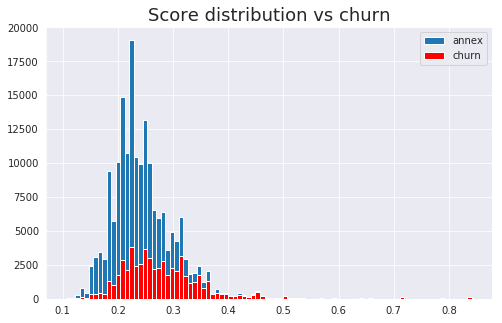

In [172]:
plt.figure(figsize=(8, 5))
plt.title("Score distribution vs churn", fontsize=18)
plt.hist(scored_pd.loc[scored_pd.churn == 0, :].score, label="annex", bins=90)
plt.hist(scored_pd.loc[scored_pd.churn == 1, :].score, label="churn", bins=90, color="r")
plt.legend()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0ba9159438>,
      dtype=object)

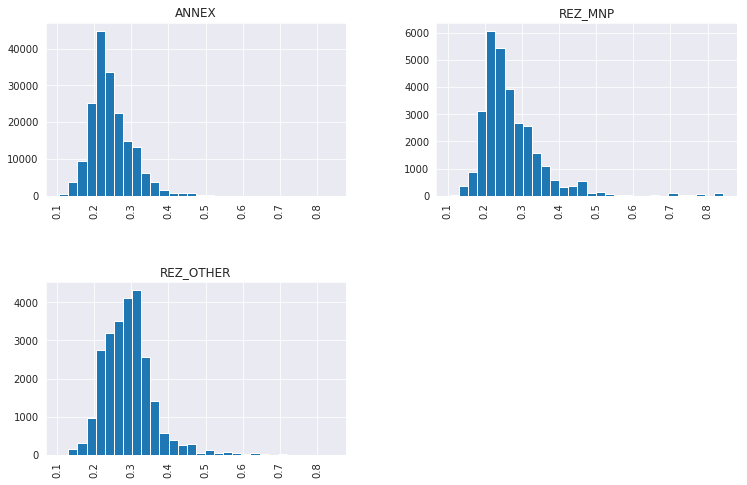

In [173]:
scored_pd.hist("score", "decision", bins=30, figsize=(12, 8))

In [196]:
scored_pd.drop(["cont_id", "churn"], axis=1).groupby("decision").mean()

length     score  expected_lift  patterns_matched
decision                                                      
ANNEX      3.953660  0.244959  1.049609       1.710371        
REZ_MNP    4.399920  0.270909  1.160806       1.851719        
REZ_OTHER  4.309152  0.292205  1.252056       1.890334

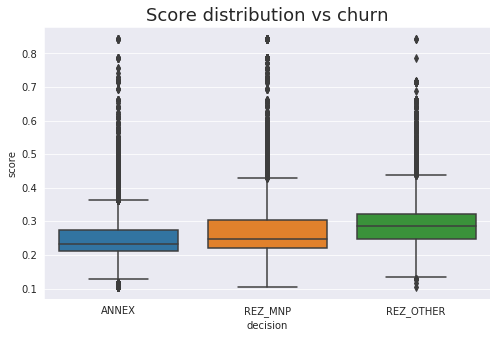

In [174]:
plt.figure(figsize=(8, 5))
plt.title("Score distribution vs churn", fontsize=18)
sns.boxplot("decision", "score", data=scored_pd)

## ROC and Precision vs Recall

ROC and Precision vs Recall are not the best methods to assess EBR models because in this case, we are focused on relatively small subset of population with high probability of churn and we do not care too much for the rest of the population which even might be not scored if no significant patterns/events are observed.<br>

Nevertheless, ROC and Precision vs Recall might be useful for many different situations and as the notebook aims for knowledge sharing, it is worth to have some useful snippets here.


In [175]:
import numpy as np
from sklearn.metrics import auc, roc_curve, precision_recall_curve

fpr, tpr, thresholds = roc_curve(scored_pd.churn, scored_pd.score, pos_label=1)
precision, recall, thresholds = precision_recall_curve(scored_pd.churn, scored_pd.score)

roc_auc = auc(fpr, tpr)

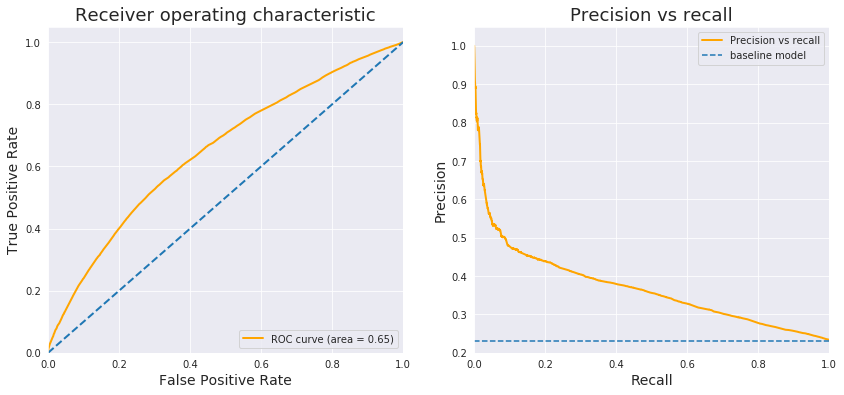

In [176]:
# plt.figure(figsize=(6, 6))

lw = 2
fig, ax = plt.subplots(1, 2, figsize=(14, 6))


ax[0].plot(fpr, tpr, color='orange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
ax[0].plot([0, 1], [0, 1], lw=lw, linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate', fontsize=14)
ax[0].set_ylabel('True Positive Rate', fontsize=14)
ax[0].set_title('Receiver operating characteristic', fontsize=18)
ax[0].legend(loc="lower right")

ax[1].plot(recall, precision, color='orange', lw=lw, label='Precision vs recall')
ax[1].plot([0, 1], [0.23, 0.23], linestyle='--', label="baseline model")
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.2, 1.05])
ax[1].set_xlabel('Recall', fontsize=14)
ax[1].set_ylabel('Precision', fontsize=14)
ax[1].set_title('Precision vs recall', fontsize=18)
ax[1].legend(loc="best")


plt.show()

### End of Discovery

# Next steps for full scale integration and deployment

<ol>
    <li> Re-run the notebook if some changes are required (like increasing time delta parameter and other business related changes)
    <li> Generate new events if new discovery is required
    <li> Prepare data lineage and TDM entries for all relevant events used in final model
    <li> Implement / port to HALO all scripts responsible for generating needed events
    <li> Schedule jobs for daily scorings and model recalculations if self-learning is needed, daily scorings will be available in Hive
    <li> Run campaign on regular/daily basis
</ol>
    

In [10]:
spark.sql("show databases").show(200, False)

+----------------+
|databaseName    |
+----------------+
|capex_allocation|
|default         |
|ebr             |
|ebr_test        |
|pa_outputs      |
|tdatamodel      |
|tmodel          |
+----------------+



In [17]:
spark.sql("use pa_outputs").show(200, False)

++
||
++
++



In [18]:
spark.sql("show tables").show(200, False)

+----------+-----------------------+-----------+
|database  |tableName              |isTemporary|
+----------+-----------------------+-----------+
|pa_outputs|pa_postpaid_priv_events|false      |
|pa_outputs|pa_postpaid_priv_paths |false      |
|pa_outputs|pa_postpaid_soho_events|false      |
|pa_outputs|pa_postpaid_soho_paths |false      |
|pa_outputs|pa_postpaid_vse_events |false      |
|pa_outputs|pa_postpaid_vse_paths  |false      |
+----------+-----------------------+-----------+



In [20]:
spark.sql("select * from pa_postpaid_priv_paths limit 20").show(10)

+---------+--------------------+------+-----------------+-------------------+--------------------+--------------------+
|       id|          event_path|length|terminating_event|    terminator_time|         event_times|              events|
+---------+--------------------+------+-----------------+-------------------+--------------------+--------------------+
|100144321|[bills_nonpayer, ...|     3|            CHURN|2019-02-14 13:33:21|[2019-01-11 00:00...|[[bills_nonpayer]...|
|100160599|[POACH_WWW_USAGE_...|     6|            ANNEX|2019-04-09 00:00:00|[2019-01-16 15:43...|[[POACH_WWW_USAGE...|
|100181623|[AREA_A:TD_RIR_UN...|     4|            ANNEX|2019-04-11 00:00:00|[2019-02-04 14:51...|[[AREA_A:TD_RIR_U...|
|100192291|[CC_SAVE_DESK:TD_...|     1|            CHURN|2019-03-13 15:39:11|[2019-02-18 08:20...|[[CC_SAVE_DESK:TD...|
|100232862|[CC_TELESALES_FOC...|     3|            ANNEX|2019-04-25 00:00:00|[2019-03-28 12:15...|[[CC_TELESALES_FO...|
|100756282|[CC_TELESALES:TD_...|     9| 

In [21]:
spark.sql("select * from pa_postpaid_soho_paths  limit 20").show(10)

+---+----------+------+-----------------+---------------+-----------+------+
| id|event_path|length|terminating_event|terminator_time|event_times|events|
+---+----------+------+-----------------+---------------+-----------+------+
+---+----------+------+-----------------+---------------+-----------+------+



In [24]:
spark.sql("select event, count(*) ile from pa_postpaid_soho_events group by event order by 2 desc").show(200, False)

+--------------------------------------------------------------+------+
|event                                                         |ile   |
+--------------------------------------------------------------+------+
|CC_TELESALES:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT                |119558|
|bill_shocking                                                 |103961|
|often_interactions2                                           |101679|
|CC_RETENTION:TD_RIR_0.0_0.3:HOTLINE_KONSULTANT                |95001 |
|DEALERS:TD_RIR_0.3_0.5:FRKONSULTANT                           |49862 |
|OTHER:TD_RIR_UNKN:KIWI                                        |46210 |
|CC_TELESALES_FOC:TD_RIR_0.0_0.3:HOTLINE_FOC                   |45623 |
|atg_visit                                                     |41596 |
|DEALERS:TD_RIR_0.0_0.3:FRKONSULTANT                           |32556 |
|comp_call_WWW                                                 |30117 |
|bills_nonpayer                                                |

In [22]:
spark.sql("select * from pa_postpaid_vse_paths limit 20").show(10)

+---+----------+------+-----------------+---------------+-----------+------+
| id|event_path|length|terminating_event|terminator_time|event_times|events|
+---+----------+------+-----------------+---------------+-----------+------+
+---+----------+------+-----------------+---------------+-----------+------+



In [12]:
spark.sql("select * from events_postpaid_churn limit 20").show(200, False)

+--------+--------+-------------------+-------------------+----+
|cont_id |decision|decision_date      |expire_date        |seg |
+--------+--------+-------------------+-------------------+----+
|22550381|ANNEX   |2018-01-09 00:00:00|2017-12-28 00:00:00|SOHO|
|22550489|ANNEX   |2018-08-30 00:00:00|2018-10-17 00:00:00|PRIV|
|22550765|REZ_MNP |2017-10-20 11:23:41|2017-11-22 00:00:00|VSE |
|22550994|ANNEX   |2018-03-19 00:00:00|2018-02-20 00:00:00|SOHO|
|22551037|ANNEX   |2018-08-02 00:00:00|2019-01-12 00:00:00|PRIV|
|22551468|ANNEX   |2018-07-30 00:00:00|2018-09-06 00:00:00|PRIV|
|22551491|ANNEX   |2019-02-23 00:00:00|2019-05-22 00:00:00|VSE |
|22551528|ANNEX   |2018-05-19 00:00:00|2018-08-04 00:00:00|PRIV|
|22551812|ANNEX   |2017-07-31 00:00:00|2017-12-19 00:00:00|PRIV|
|22551986|ANNEX   |2019-01-10 00:00:00|2019-03-28 00:00:00|PRIV|
|22551996|ANNEX   |2017-07-31 00:00:00|2017-10-02 00:00:00|PRIV|
|22552123|ANNEX   |2018-08-21 00:00:00|2018-12-22 00:00:00|PRIV|
|22552328|ANNEX   |2017-0

In [14]:
spark.sql("select decision, count(*) ile from events_postpaid_churn group by decision").show(200, False)

+---------+-------+
|decision |ile    |
+---------+-------+
|REZ_MNP  |359970 |
|ANNEX    |2070112|
|REZ_OTHER|232312 |
+---------+-------+



In [15]:
spark.sql("select * from events_postpaid limit 20").show(200, False)

+---------+-------------------+----------+----------------------------------------------+-----------------------+--------------------------+-----------------------+
|cont_id  |event_dt           |event_type|event_name                                    |event_name_extended    |event_description         |insert_ts              |
+---------+-------------------+----------+----------------------------------------------+-----------------------+--------------------------+-----------------------+
|148471624|2018-09-11 12:07:34|TD_RIR    |OTHER:TD_RIR_UNKN:KIWI                        |KIWI                   |Kontakt Klient <> T-Mobile|2018-09-12 02:01:26.374|
|64168464 |2018-09-11 12:07:34|TD_RIR    |UNKNOWN:TD_RIR_UNKN:HOTLINE_FOC               |HOTLINE_FOC            |Kontakt Klient <> T-Mobile|2018-09-12 02:01:26.374|
|148902781|2018-09-11 12:07:35|TD_RIR    |OTHER:TD_RIR_UNKN:KIWI                        |KIWI                   |Kontakt Klient <> T-Mobile|2018-09-12 02:01:26.374|
|148920364

In [16]:
spark.sql("select event_type, count(*) ile from events_postpaid group by event_type").show(200, False)

+-------------------------+--------+
|event_type               |ile     |
+-------------------------+--------+
|competition_pos          |4634632 |
|null                     |98      |
|atg                      |445873  |
|poach_call               |529068  |
|int_feedback             |261366  |
|bills                    |10250903|
|dunning                  |8948809 |
|zwroty                   |34446   |
|REKLAMACJA_STOP_NEGATYWNA|203488  |
|SNA_churn                |275945  |
|TD_RIR                   |45286924|
|MKT_ZGODA                |55282   |
|voice_interaction        |6945076 |
|int_nice                 |599399  |
|REKLAMACJA_START         |236788  |
+-------------------------+--------+

